## HKA test
#### multi_sub_download
for i in chr{1..22};do wget https://hgdownload-test.gi.ucsc.edu/goldenPath/hg38/multiz100way/maf/ 𝑖.𝑚𝑎𝑓.𝑔𝑧;𝑐𝑎𝑡
 {i}.maf.gz >> hg38.maf.gz;done cat ${i}.maf.gz >> hg38.maf.gz
 ```
 the HKA test was referred to Guiblet et.al. Selection and thermostability suggest G-quadruplexes are novel functional elements of the human genome. *Genome Research*, 2021.

In [ ]:
# sub.py
import sys
import re


infile = open("/disk2/project/UCSC/100ways/WG_hg38.maf", 'rt')
outfile = open("/disk2/G4_MS/frequency/HKA/data/Substitutions.bed",'w')
parsed = {}

h_motif = None
p_motif = None



nucl_mapping = str.maketrans("actgn-","ACTGN-")

def custom_translate(input_string):
   return input_string.translate(nucl_mapping)


for line in infile:
        if line[0] == 's':
                line = line.strip()
                #print(line)
                array = re.search('[s]\ +([a-z,A-Z]+[0-9]+)\.[a-z,A-Z]+([0-9,\.,\_,\-,a-z,A-Z]+)\ +([0-9]+)\ +([0-9]+)\ +([+-])\ +[0-9]+\ +([a-z,A-z,\-]+)', line)
                if 'hg38' == array.group(1):
                        h_chrom = array.group(2)
                        h_start = array.group(3)
                        h_length = array.group(4)
                        h_strand = array.group(5)
                        h_motif = array.group(6)

                if 'ponAbe2' == array.group(1):
                        p_chrom = array.group(2)
                        p_start = array.group(3)
                        p_length = array.group(4)
                        p_strand = array.group(5)
                        p_motif = array.group(6)


        if line[0] == 'a' and h_motif and p_motif:

                h_motif = custom_translate(h_motif)
                p_motif = custom_translate(p_motif)
                pos = 0
                
                compare = zip(h_motif, p_motif)
                for nuc in compare:
                    if nuc[0] != '-':
                        if nuc[0] != nuc[1]:
                            outfile.write('chr'+h_chrom+'\t'+str(int(h_start)+pos+1)+'\t'+str(int(h_start)+pos+2)+'\t'+nuc[0]+'\t'+nuc[1]+'\n')
                        else:
                            outfile.write('chr'+h_chrom+'\t'+str(int(h_start)+pos+1)+'\t'+str(int(h_start)+pos+2)+'\tNo\tNo\n')
                        pos += 1
                h_motif = None
                p_motif = None
        elif line[0] == 'a' and h_motif:
            for i in range(int(h_start),int(h_start)+int(h_length)):
                outfile.write('chr'+h_chrom+'\t'+str(i+1)+'\t'+str(i+2)+'\tNA\tNA\n')

In [ ]:
# save as locuschoice.py not run with through jupyter
import random
import sys

bedfile = open(sys.argv[1], 'rt')
outfile = open(sys.argv[2], 'w+')

last_chrom = 'chr0'
last_end = 0

tochoose = []

for line in bedfile:
    array = line.strip().split("\t")
    chrom = array[0]
    start = array[1]
    end = array[2]
    
    if chrom == last_chrom:
        if int(start) < last_end:
            tochoose.append(array)
            last_end = int(end)
        else:
            chosenmotif = tochoose[random.randint(0,len(tochoose)-1)]
            for field in chosenmotif[0:-1]:
                outfile.write(str(field)+ "\t")
            outfile.write(chosenmotif[-1] + "\n")
            tochoose = [array]
            last_chrom = chrom
            last_end = int(end)
    else:
        if len(tochoose) > 0:
            chosenmotif = tochoose[random.randint(0,len(tochoose) -1)]
            for field in chosenmotif[0:-1]:
                outfile.write(str(field) + "\t")
            outfile.write(chosenmotif[-1] + "\n")
            
            tochoose = [array]
            last_chrom = chrom
            last_end = int(end)
        else:
            tochoose = [array]
            last_chrom = chrom
            last_end = int(end)
else:
    chosenmotif = tochoose[random.randint(0,len(tochoose)-1)]
    for field in chosenmotif[0:-1]:
        outfile.write(str(field)+ "\t")
    outfile.write(chosenmotif[-1] + "\n")


In [ ]:
%%bash
python locuschoice.py active_promoter_info.annotion.bed active_promoter.bed
python locuschoice.py promoter.annotion.bed promoter.bed


In [ ]:
## G4_split.py
import pandas as pd
import numpy as np
import os
import sys
import pyranges as pr
import inspect
from itertools import groupby, product
from Bio import SeqIO
import warnings

warnings.filterwarnings("ignore")

def retrieve_name(var):
    '''
    utils:
    get back the name of variables
    '''
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]


def Gtrack_get(seq, plus=True):
    result = []
    ggg = []
    seqindex = []
    for index, val in enumerate(list(seq)):
        if plus:
            if val == 'g' or val == 'G':
                ggg.append(index)
        else:
            if val == 'c' or val == 'C':
                ggg.append(index)
    for k, g in groupby(enumerate(ggg), lambda x: x[1] - x[0]):
        _ = [j for i, j in g]
        if len(_) >= 3:
            seqindex.append(_)
    if len(seqindex) > 0:
        for idx in seqindex:
            result.append((idx[0], idx[-1] + 1))
    return result
    
    
def G4_info(df):
    result = []
    df = df.drop_duplicates(keep="first", subset=["Chromosome", "Start", "End"])
    df = df[df["Chromosome"] != "chrX"]
    df = df[df["Chromosome"] != "chrY"]
    df = df[df["G4_length"] <= 100]
    g4_numbers = 0
    g4_lengths = 0
    grunsNumbers = 0
    gloopNumbers = 0
    for index, row in df.iterrows():
        g4_numbers += 1
        g4_lengths += row.G4_length
        plusflg = True
        if row["Strand"] == "-": plusflg = False
        tp_track = Gtrack_get(row["G4_seq"], plus=plusflg)
        stem = []
        loop = []
        for i in range(len(tp_track) - 1):
            if plusflg:
                stem_tmp = [row["Chromosome"], row["Start"] + tp_track[i][0], row["Start"] + tp_track[i][1], "+",
                            "stem"]
                stem.append(stem_tmp)
                loop_tmp = [row["Chromosome"], row["Start"] + tp_track[i][1], row["Start"] + tp_track[i + 1][0], "+",
                            "loop"]
                loop.append(loop_tmp)
            else:
                stem_tmp = [row["Chromosome"], row["Start"] + tp_track[i][0], row["Start"] + tp_track[i][1], "-",
                            "stem"]
                stem.append(stem_tmp)
                loop_tmp = [row["Chromosome"], row["Start"] + tp_track[i][1], row["Start"] + tp_track[i + 1][0], "-",
                            "loop"]
                loop.append(loop_tmp)
        if plusflg:
            stem_tmp = [row["Chromosome"], row["Start"] + tp_track[-1][0], row["Start"] + tp_track[-1][1], "+", "stem"]
            flank1 = [row["Chromosome"], row["Start"] + tp_track[0][0] - 100, row["Start"] + tp_track[0][0], "+",
                      "flank1"]
            flank2 = [row["Chromosome"], row["Start"] + tp_track[-1][1], row["Start"] + tp_track[-1][1] + 100, "+",
                      "flank2"]
        else:
            stem_tmp = [row["Chromosome"], row["Start"] + tp_track[-1][0], row["Start"] + tp_track[-1][1], "-", "stem"]
            flank2 = [row["Chromosome"]] + [row["Start"] + tp_track[0][0] - 100, row["Start"] + tp_track[0][0], "-",
                                            "flank2"]
            flank1 = [row["Chromosome"]] + [row["Start"] + tp_track[-1][1], row["Start"] + tp_track[-1][1] + 100, "-",
                                            "flank1"]
        stem.append(stem_tmp)
        result += stem
        result += loop
        grunsNumbers += len(tp_track)
        gloopNumbers += len(tp_track) - 1
        result += [flank1, flank2]
    return result, g4_numbers, g4_lengths / g4_numbers, grunsNumbers, gloopNumbers


def file_check(path):
    if not os.path.isfile(path):
        sys,exit(f"this file {path} is not exist !!!")
    else:
        return path

def G4_split(promoter_pG4):
    """
    promoter_pG4: pG4 bed file that contains pG4 sequence and Strand 
    return: G-tracts, loop and other pG4 info such as the mean length and numbers of pG4
    
    """
    varname = retrieve_name(promoter_pG4)
    promoter_pG4_info, g4numbers, g4_mean_length, g4stemNumber, g4loopNumber = G4_info(promoter_pG4)
    print(varname)
    print(g4numbers, g4_mean_length, g4stemNumber, g4loopNumber)
    promoter_pG4_info = pd.DataFrame(promoter_pG4_info, columns=["Chromosome", "Start", "End", "Strand", "type"])
    promoter_pG4_info_Gtracts = promoter_pG4_info[promoter_pG4_info["type"] == "stem"]
    promoter_pG4_info_loops = promoter_pG4_info[promoter_pG4_info["type"] == "loop"]
    return promoter_pG4_info_Gtracts, promoter_pG4_info_loops
    
def promoter_select(promoter, promoter_pG4, promoter_name, gruns, WD_PATH):
    G4 = pd.read_table("/disk2/G4_MS/G4_identify/Quadron/hs38d2.quadron.bed", header=None, 
                       names=["Chromosome", "Start", "End", "G4_seq", "G4_length","Strand","G4_score"])
    G4 = pr.PyRanges(G4)
    promoter_pG4 = promoter_pG4.overlap(promoter, strandedness=False)
    promoter_pG4_Stable = promoter_pG4[promoter_pG4.Score > 19]
    promoter_pG4_unStable = promoter_pG4[promoter_pG4.Score < 19]
    promoter_noG4 = promoter.subtract(G4, strandedness=False).merge()
    promoter_pG4.to_csv(os.path.join(WD_PATH, promoter_name + "_pG4.info.tsv"), sep="\t")
    promoter_pG4_Stable.to_csv(os.path.join(WD_PATH, promoter_name + "_pG4_Stable.info.tsv"), sep="\t")
    promoter_pG4_unStable.to_csv(os.path.join(WD_PATH, promoter_name + "_pG4_unStable.info.tsv"), sep="\t")
    promoter_noG4.to_csv(os.path.join(WD_PATH, promoter_name + "_noG4.info.tsv"), sep="\t")
    # G-tracts analysis
    promoter_G4_Gtract = gruns.overlap(promoter_pG4, strandedness=False)
    promoter_stableG4_Gtract = gruns.overlap(promoter_pG4_Stable, strandedness=False)
    promoter_unstable_Gtracts = gruns.overlap(promoter_pG4_unStable, strandedness=False)
    promoter_nonG4_Gtract = gruns.overlap(promoter_noG4, strandedness=False)
    promoter_G4_Gtract.to_bed(os.path.join(WD_PATH,promoter_name + "_pG4_Gtract.bed"))
    promoter_stableG4_Gtract.to_bed(os.path.join(WD_PATH, promoter_name + "_stableG4_Gtract.bed"))
    promoter_unstable_Gtracts.to_bed(os.path.join(WD_PATH, promoter_name + "_unstable_Gtracts.bed"))
    promoter_nonG4_Gtract.to_bed(os.path.join(WD_PATH,promoter_name + "_nonG4_Gtract.bed"))


WD_PATH = "/disk2/G4_MS/frequency/HKA/data/promoterInfo"
# DATA_PTAH = "/disk2/G4_MS/promoter_select/promoter_info"
REFERENCE_PTAH = "/disk2/G4_MS/reference"

cds_path = file_check(os.path.join(REFERENCE_PTAH, "gencode38.cds_region.bed"))
cds = pr.read_bed(cds_path)
G4 = pd.read_table("/disk2/G4_MS/G4_identify/Quadron/hs38d2.quadron.bed", header=None,
                   names=["Chromosome", "Start", "End", "G4_seq", "G4_length","Strand","G4_score"])
G4 = pr.PyRanges(G4)
gruns_path = file_check(os.path.join(REFERENCE_PTAH, "genomic_Gruns.bed"))
gruns = pr.PyRanges(pd.read_table(gruns_path, header=None, names=["Chromosome", "Start", "End", "Strand", "Gtract"]))

## promoter select
promoter = pr.PyRanges(pd.read_table(os.path.join(WD_PATH,"promoter.bed"),header=None, 
                                     names="Chromosome	Start	End	Promoter_id	gene_id	Strand	transcript_id	gene_type	gene_name".split("\t")))
promoter = promoter.subtract(cds,strandedness=False)
promoter_pG4 = G4.overlap(promoter,strandedness=False).as_df()
promoter_pG4_Gtracts, promoter_pG4_loop = G4_split(promoter_pG4)
promoter_pG4.to_csv(os.path.join(WD_PATH,"promoter_pG4.info.tsv"),sep="\t",index=False)
promoter_pG4_Gtracts.to_csv(os.path.join(WD_PATH,"promoter_pG4_Gtract.bed"),sep="\t",header=False, index=False)
promoter_pG4_loop.to_csv(os.path.join(WD_PATH,"tss_loop_pG4.subtype.tsv"),sep="\t",header=False, index=False)

promoter_pG4_Stable = promoter_pG4[promoter_pG4.G4_score > 19]
promoter_pG4_Stable_Gtracts, promoter_pG4_Stable_loop = G4_split(promoter_pG4_Stable)
promoter_pG4_Stable.to_csv(os.path.join(WD_PATH,"promoter_pG4_Stable.info.tsv"),sep="\t",index=False)
promoter_pG4_Stable_Gtracts.to_csv(os.path.join(WD_PATH,"promoter_stableG4_Gtract.bed"),sep="\t",header=False, index=False)
promoter_pG4_Stable_loop.to_csv(os.path.join(WD_PATH,"tss_stable.pG4.loop.tsv"),sep="\t",header=False, index=False)

promoter_pG4_unStable = promoter_pG4[promoter_pG4.G4_score <= 19]
promoter_pG4_unStablee_Gtracts, promoter_pG4_unStable_loop = G4_split(promoter_pG4_unStable)
promoter_pG4_unStable.to_csv(os.path.join(WD_PATH,"promoter_pG4_unStable.info.tsv"),sep="\t",index=False)
promoter_pG4_unStablee_Gtracts.to_csv(os.path.join(WD_PATH,"promoter_unstable_Gtracts.bed"),sep="\t",header=False, index=False)
promoter_pG4_unStable_loop.to_csv(os.path.join(WD_PATH,"tss_unstable.pG4.loop.tsv"),sep="\t",header=False, index=False)

# # nonG4
promoter_nonG4 = promoter.subtract(G4,strandedness=False)
promoter_nonG4_Gtracts = gruns.overlap(promoter_nonG4,strandedness=False)
promoter_nonG4.as_df().to_csv(os.path.join(WD_PATH,"promoter_noG4.info.tsv"),sep="\t",index=False)
promoter_nonG4_Gtracts.to_bed(os.path.join(WD_PATH,"promoter_nonG4_Gtract.bed"))
# ## active promoter get
active_promoter = pr.PyRanges(pd.read_table(os.path.join(WD_PATH,"active_promoter.bed"),header=None,
                                           names="Chromosome	Start	End	Promoter_id	gene_id	Strand	transcript_id	gene_type	gene_name	Start_tss	End_tss".split("\t")))
active_promoter = active_promoter.subtract(cds,strandedness=False)

active_promoter_pG4 = G4.overlap(active_promoter,strandedness=False).as_df()
active_promoter_pG4_Gtracts, active_promoter_pG4_loop = G4_split(active_promoter_pG4)
active_promoter_pG4.to_csv(os.path.join(WD_PATH,"active_promoter_pG4.info.tsv"),sep="\t",index=False)
active_promoter_pG4_Gtracts.to_csv(os.path.join(WD_PATH,"active_promoter_pG4_Gtract.bed"),sep="\t",header=False, index=False)
active_promoter_pG4_loop.to_csv(os.path.join(WD_PATH,"epG4_loop.subtype.tsv"),sep="\t",header=False, index=False)

active_promoter_pG4_Stable = active_promoter_pG4[active_promoter_pG4.G4_score > 19]
active_promoter_pG4_Stable_Gtracts, active_promoter_pG4_Stable_loop = G4_split(active_promoter_pG4_Stable)
active_promoter_pG4_Stable.to_csv(os.path.join(WD_PATH,"active_promoter_pG4_Stable.info.tsv"),sep="\t",index=False)
active_promoter_pG4_Stable_Gtracts.to_csv(os.path.join(WD_PATH,"active_promoter_stableG4_Gtract.bed"),sep="\t",header=False, index=False)
active_promoter_pG4_Stable_loop.to_csv(os.path.join(WD_PATH,"stable_epG4.loop.tsv"),sep="\t",header=False, index=False)

active_promoter_pG4_unStable = active_promoter_pG4[active_promoter_pG4.G4_score <= 19]
active_promoter_pG4_unStable_Gtracts, active_promoter_pG4_unStable_loop = G4_split(active_promoter_pG4_unStable)
active_promoter_pG4_unStable.to_csv(os.path.join(WD_PATH,"active_promoter_pG4_unStable.info.tsv"),sep="\t",index=False)
active_promoter_pG4_unStable_Gtracts.to_csv(os.path.join(WD_PATH,"active_promoter_unstable_Gtracts.bed"),sep="\t",header=False, index=False)
active_promoter_pG4_unStable_loop.to_csv(os.path.join(WD_PATH,"unstable_epG4.loop.tsv"),sep="\t",header=False, index=False)
# #nonG4
active_promoter_nonG4 = active_promoter.subtract(G4)
active_promoter_nonG4_Gtracts = gruns.overlap(active_promoter_nonG4,strandedness=False)
active_promoter_nonG4_Gtracts.to_bed(os.path.join(WD_PATH,"active_promoter_nonG4_Gtract.bed"))


In [ ]:
%%bash
python sub.py
ptrhon G4_split.py
cd /disk2/G4_MS/frequency/HKA/data
cat promoterInfo/promoter.bed promoterInfo/active_promoter.bed |cut -f1-6 |bedtools sort -i -|bedtools merge -i -|bedtools intersect -a 100way.Substitutions.bed.gz -b - |gzip > 100way.promoter.Substitutions.bed.gz
cat promoterInfo/promoter.bed promoterInfo/active_promoter.bed |cut -f1-6 |bedtools sort -i -|bedtools merge -i -|bedtools intersect -a 1000G_PASS_SNP_EUR.tsv.gz -b - |gzip > promoter.1000G_PASS_SNP_EUR.tsv.gz
cat promoterInfo/promoter.bed promoterInfo/active_promoter.bed |cut -f1-6 |bedtools sort -i -|bedtools merge -i -|bedtools intersect -a 1000G_PASS_SNP_EAS.tsv.gz -b - |gzip > promoter.1000G_PASS_SNP_EAS.tsv.gz
cat promoterInfo/promoter.bed promoterInfo/active_promoter.bed |cut -f1-6 |bedtools sort -i -|bedtools merge -i -|bedtools intersect -a 1000G_PASS_SNP_SAS.tsv.gz -b - |gzip > promoter.1000G_PASS_SNP_SAS.tsv.gz
cat promoterInfo/promoter.bed promoterInfo/active_promoter.bed |cut -f1-6 |bedtools sort -i -|bedtools merge -i -|bedtools intersect -a 1000G_PASS_SNP_AMR.tsv.gz -b - |gzip > promoter.1000G_PASS_SNP_AMR.tsv.gz
cat promoterInfo/promoter.bed promoterInfo/active_promoter.bed |cut -f1-6 |bedtools sort -i -|bedtools merge -i -|bedtools intersect -a 1000G_PASS_SNP_AFR.tsv.gz -b - |gzip > promoter.1000G_PASS_SNP_AFR.tsv.gz
cat promoterInfo/promoter.bed promoterInfo/active_promoter.bed |cut -f1-6 |bedtools sort -i -|bedtools merge -i -|bedtools intersect -a 1000G_PASS_SNP_merge.tsv.gz -b - |gzip > promoter.1000G_PASS_SNP_merge.tsv.gz


In [ ]:
# -*- coding: utf-8 -*-
# @Time    : 2022/11/7 9:28
# @Author  : Guangyuel
# @file    : evolution_HKA_analysis.py
## this script was refered to Guiblet et.al Selection and thermostability suggest G-quadruplexes are novel functional elements of the human genome, PMID: 34187812
import sys
import pandas as pd
import os


WORK_PATH = "/disk2/G4_MS/frequency/HKA"


class SNPS:
    def __init__(self, snp_path):
        self.snp = None
        self.path = snp_path

    def snp_filter(self, alle_number):
        self.snp = pd.read_table(self.path, header=None,
                                 names=['Chromosome', "Start", "End", "ref", "alt", "filtered", "mutType", "ac", "an"],
                                 compression="gzip"
                                 )
        self.snp.loc[:, "ac"] = self.snp.groupby(["Chromosome", "Start", "End"])["ac"].transform("sum")
        self.snp.loc[:, "an"] = self.snp.groupby(["Chromosome", "Start", "End"])["an"].transform("mean")
        # notice this pos ref, alt was not assoated with ac and an ,the ac or an is the chromosome pos counts
        self.snp = self.snp.drop_duplicates(["Chromosome", "Start", "End"])
#         self.snp = self.snp[self.snp["an"] >= int(alle_number)*0.8]
        self.snp.loc[:, "maf"] = self.snp.apply(lambda x: x["ac"]/x["an"], axis=1)
        self.snp.loc[:, "key"] = self.snp["Chromosome"].map(str) + "|" + self.snp["Start"].map(str) + "|" + self.snp["End"].map(str)
        self.snp = self.snp.loc[:, ["key", "ref", "alt", "maf"]]


class SUB:
    def __init__(self, path):
        self.subs = None
        self.path = path

    def substitution_filter(self):
        self.subs = pd.read_table(self.path, header=None,
                                  names=['Chromosome', "Start", "End", "homo", "pongo"], dtype=object,
                                  compression="gzip"
                                  )
        self.subs.loc[:, "key"] = self.subs["Chromosome"].map(str) + "|" + self.subs["Start"].map(str) + "|" + self.subs["End"].map(str)
        self.subs = self.subs.loc[:, ["key", "homo", "pongo"]]


snp_path = sys.argv[1]
outputname = sys.argv[2]
alle_number = sys.argv[3]
snp = SNPS(os.path.join(WORK_PATH, "data", snp_path))
snp.snp_filter(alle_number)
subs = SUB(os.path.join(WORK_PATH, "data", "100way.promoter.Substitutions.bed.gz"))
subs.substitution_filter()
print("prepare analysis done")
merge_df = subs.subs.merge(snp.snp, how="outer", on="key")
merge_df = merge_df.fillna("NA")
merge_df["Chromosome"], merge_df["Start"], merge_df["End"] = merge_df["key"].str.split("|").str
merge_df["homo|pongo|ref|alts|maf"] = merge_df["homo"].map(str)+"|"+merge_df["pongo"].map(str)+"|"+merge_df["ref"]+ "|" + merge_df["alt"]+"|"+merge_df["maf"].map(str)
merge_df = merge_df.loc[:, ["Chromosome", "Start", "End", "homo|pongo|ref|alts|maf"]]
merge_df.to_csv(os.path.join(WORK_PATH, outputname + ".Sites.tab"), sep="\t", index=False)

In [ ]:
%%bash
## merged substitutions with snps
cd /disk2/G4_MS/frequency/HKA
python /usr/G4_pipline/evolution_HKA_analysis.py promoter.1000G_PASS_SNP_merge.tsv.gz promoter_kg_merge 5008
python /usr/G4_pipline/evolution_HKA_analysis.py promoter.1000G_PASS_SNP_EUR.tsv.gz promoter_kg_EUR 1006
python /usr/G4_pipline/evolution_HKA_analysis.py promoter.1000G_PASS_SNP_EAS.tsv.gz promoter_kg_EAS 1008
python /usr/G4_pipline/evolution_HKA_analysis.py promoter.1000G_PASS_SNP_SAS.tsv.gz promoter_kg_SAS 978
python /usr/G4_pipline/evolution_HKA_analysis.py promoter.1000G_PASS_SNP_AMR.tsv.gz promoter_kg_AMR 694
python /usr/G4_pipline/evolution_HKA_analysis.py promoter.1000G_PASS_SNP_AFR.tsv.gz promoter_kg_AFR 1322

In [ ]:
%%bash
## G4 groupby analysis
cd /disk2/G4_MS/frequency/HKA
tail -n +2 data/promoterInfo/promoter_pG4.info.tsv|cut -f 1-3|sort -k1,1 -k2,2n|uniq|grep -v "chrX"|grep -v "chrY" > promoter_pG4.info.bed
tail -n +2 data/promoterInfo/promoter_pG4_Stable.info.tsv|cut -f 1-3|sort -k1,1 -k2,2n|uniq|grep -v "chrX"|grep -v "chrY" > promoter_pG4_Stable.info.bed
tail -n +2 data/promoterInfo/promoter_pG4_unStable.info.tsv|cut -f 1-3|sort -k1,1 -k2,2n|uniq|grep -v "chrX"|grep -v "chrY" > promoter_pG4_unStable.info.bed
tail -n +2 data/promoterInfo/promoter_noG4.info.tsv|cut -f 1-3|sort -k1,1 -k2,2n|uniq|grep -v "chrX"|grep -v "chrY" > promoter_noG4.info.bed


cat data/promoterInfo/promoter_pG4_Gtract.bed|cut -f 1-3|sort -k1,1 -k2,2n|uniq|grep -v "chrX"|grep -v "chrY" > promoter_pG4_Gtract.bed
cat data/promoterInfo/promoter_stableG4_Gtract.bed|cut -f 1-3|sort -k1,1 -k2,2n|uniq|grep -v "chrX"|grep -v "chrY" > promoter_stableG4_Gtract.bed
cat data/promoterInfo/promoter_unstable_Gtracts.bed|cut -f 1-3|sort -k1,1 -k2,2n|uniq|grep -v "chrX"|grep -v "chrY" > promoter_unstable_Gtracts.bed
cat data/promoterInfo/promoter_nonG4_Gtract.bed|cut -f 1-3|sort -k1,1 -k2,2n|uniq|grep -v "chrX"|grep -v "chrY" > promoter_nonG4_Gtract.bed

cat data/promoterInfo/tss_loop_pG4.subtype.tsv|cut -f 1-3|sort -k1,1 -k2,2n|uniq|grep -v "chrX"|grep -v "chrY" > promoter_pG4.loop.bed
cat data/promoterInfo/tss_stable.pG4.loop.tsv|cut -f 1-3|sort -k1,1 -k2,2n|uniq|grep -v "chrX"|grep -v "chrY" > promoter_stable.pG4.loop.bed
cat data/promoterInfo/tss_unstable.pG4.loop.tsv|cut -f 1-3|sort -k1,1 -k2,2n|uniq|grep -v "chrX"|grep -v "chrY" > promoter_unstable.pG4.loop.bed

### active promoter

tail -n +2 data/promoterInfo/active_promoter_pG4.info.tsv|cut -f 1-3|sort -k1,1 -k2,2n|uniq|grep -v "chrX"|grep -v "chrY" > active_promoter_pG4.info.bed
tail -n +2 data/promoterInfo/active_promoter_pG4_Stable.info.tsv|cut -f 1-3|sort -k1,1 -k2,2n|uniq|grep -v "chrX"|grep -v "chrY" > active_promoter_pG4_Stable.info.bed
tail -n +2 data/promoterInfo/active_promoter_pG4_unStable.info.tsv|cut -f 1-3|sort -k1,1 -k2,2n|uniq|grep -v "chrX"|grep -v "chrY" > active_promoter_pG4_unStable.info.bed
tail -n +2 data/promoterInfo/active_promoter_noG4.info.tsv|cut -f 1-3|sort -k1,1 -k2,2n|uniq|grep -v "chrX"|grep -v "chrY" > active_promoter_noG4.info.bed


cat data/promoterInfo/active_promoter_pG4_Gtract.bed|cut -f 1-3|sort -k1,1 -k2,2n|uniq|grep -v "chrX"|grep -v "chrY" > active_promoter_pG4_Gtract.bed
cat data/promoterInfo/active_promoter_stableG4_Gtract.bed|cut -f 1-3|sort -k1,1 -k2,2n|uniq|grep -v "chrX"|grep -v "chrY" > active_promoter_stableG4_Gtract.bed
cat data/promoterInfo/active_promoter_unstable_Gtracts.bed|cut -f 1-3|sort -k1,1 -k2,2n|uniq|grep -v "chrX"|grep -v "chrY" > active_promoter_unstable_Gtracts.bed
cat data/promoterInfo/active_promoter_nonG4_Gtract.bed|cut -f 1-3|sort -k1,1 -k2,2n|uniq|grep -v "chrX"|grep -v "chrY" > active_promoter_nonG4_Gtract.bed

cat data/promoterInfo/epG4_loop.subtype.tsv|cut -f 1-3|sort -k1,1 -k2,2n|uniq|grep -v "chrX"|grep -v "chrY" > active_promoter.pG4.loop.bed
cat data/promoterInfo/stable_epG4.loop.tsv|cut -f 1-3|sort -k1,1 -k2,2n|uniq|grep -v "chrX"|grep -v "chrY" > active_promoter_stable.pG4.loop.bed
cat data/promoterInfo/unstable_epG4.loop.tsv|cut -f 1-3|sort -k1,1 -k2,2n|uniq|grep -v "chrX"|grep -v "chrY" > active_promoter_unstable.pG4.loop.bed



In [ ]:
%%bash
cd /disk2/G4_MS/frequency/HKA
tail -n +2 promoter_kg_merge.Sites.tab| bedtools intersect -a - -b promoter_pG4.info.bed -u > promoter_pG4.merge.SFS
tail -n +2 promoter_kg_merge.Sites.tab| bedtools intersect -a - -b promoter_pG4_Stable.info.bed -u > promoter_pG4_Stable.merge.SFS
tail -n +2 promoter_kg_merge.Sites.tab| bedtools intersect -a - -b promoter_pG4_unStable.info.bed -u > promoter_pG4_unStable.merge.SFS
tail -n +2 promoter_kg_merge.Sites.tab| bedtools intersect -a - -b promoter_noG4.info.bed -u > promoter_nonpG4.merge.SFS

tail -n +2 promoter_kg_merge.Sites.tab| bedtools intersect -a - -b promoter_pG4_Gtract.bed -u > promoter_pG4_Gtract.merge.SFS
tail -n +2 promoter_kg_merge.Sites.tab| bedtools intersect -a - -b promoter_stableG4_Gtract.bed -u > promoter_stableG4_Gtract.merge.SFS
tail -n +2 promoter_kg_merge.Sites.tab| bedtools intersect -a - -b promoter_unstable_Gtracts.bed -u > promoter_unstable_Gtracts.merge.SFS
tail -n +2 promoter_kg_merge.Sites.tab| bedtools intersect -a - -b promoter_nonG4_Gtract.bed -u > promoter_nonG4_Gtract.merge.SFS
## EUR 
tail -n +2 promoter_kg_EUR.Sites.tab| bedtools intersect -a - -b promoter_pG4.info.bed -u > promoter_pG4.EUR.SFS
tail -n +2 promoter_kg_EUR.Sites.tab| bedtools intersect -a - -b promoter_pG4_Stable.info.bed -u > promoter_pG4_Stable.EUR.SFS
tail -n +2 promoter_kg_EUR.Sites.tab| bedtools intersect -a - -b promoter_pG4_unStable.info.bed -u > promoter_pG4_unStable.EUR.SFS
tail -n +2 promoter_kg_EUR.Sites.tab| bedtools intersect -a - -b promoter_noG4.info.bed -u > promoter_nonpG4.EUR.SFS

tail -n +2 promoter_kg_EUR.Sites.tab| bedtools intersect -a - -b promoter_pG4_Gtract.bed -u > promoter_pG4_Gtract.EUR.SFS
tail -n +2 promoter_kg_EUR.Sites.tab| bedtools intersect -a - -b promoter_stableG4_Gtract.bed -u > promoter_stableG4_Gtract.EUR.SFS
tail -n +2 promoter_kg_EUR.Sites.tab| bedtools intersect -a - -b promoter_unstable_Gtracts.bed -u > promoter_unstable_Gtracts.EUR.SFS
tail -n +2 promoter_kg_EUR.Sites.tab| bedtools intersect -a - -b promoter_nonG4_Gtract.bed -u > promoter_nonG4_Gtract.EUR.SFS
# EAS
tail -n +2 promoter_kg_EAS.Sites.tab| bedtools intersect -a - -b promoter_pG4.info.bed -u > promoter_pG4.EAS.SFS
tail -n +2 promoter_kg_EAS.Sites.tab| bedtools intersect -a - -b promoter_pG4_Stable.info.bed -u > promoter_pG4_Stable.EAS.SFS
tail -n +2 promoter_kg_EAS.Sites.tab| bedtools intersect -a - -b promoter_pG4_unStable.info.bed -u > promoter_pG4_unStable.EAS.SFS
tail -n +2 promoter_kg_EAS.Sites.tab| bedtools intersect -a - -b promoter_noG4.info.bed -u > promoter_nonpG4.EAS.SFS

tail -n +2 promoter_kg_EAS.Sites.tab| bedtools intersect -a - -b promoter_pG4_Gtract.bed -u > promoter_pG4_Gtract.EAS.SFS
tail -n +2 promoter_kg_EAS.Sites.tab| bedtools intersect -a - -b promoter_stableG4_Gtract.bed -u > promoter_stableG4_Gtract.EAS.SFS
tail -n +2 promoter_kg_EAS.Sites.tab| bedtools intersect -a - -b promoter_unstable_Gtracts.bed -u > promoter_unstable_Gtracts.EAS.SFS
tail -n +2 promoter_kg_EAS.Sites.tab| bedtools intersect -a - -b promoter_nonG4_Gtract.bed -u > promoter_nonG4_Gtract.EAS.SFS
# SAS
tail -n +2 promoter_kg_SAS.Sites.tab| bedtools intersect -a - -b promoter_pG4.info.bed -u > promoter_pG4.SAS.SFS
tail -n +2 promoter_kg_SAS.Sites.tab| bedtools intersect -a - -b promoter_pG4_Stable.info.bed -u > promoter_pG4_Stable.SAS.SFS
tail -n +2 promoter_kg_SAS.Sites.tab| bedtools intersect -a - -b promoter_pG4_unStable.info.bed -u > promoter_pG4_unStable.SAS.SFS
tail -n +2 promoter_kg_SAS.Sites.tab| bedtools intersect -a - -b promoter_noG4.info.bed -u > promoter_nonpG4.SAS.SFS

tail -n +2 promoter_kg_SAS.Sites.tab| bedtools intersect -a - -b promoter_pG4_Gtract.bed -u > promoter_pG4_Gtract.SAS.SFS
tail -n +2 promoter_kg_SAS.Sites.tab| bedtools intersect -a - -b promoter_stableG4_Gtract.bed -u > promoter_stableG4_Gtract.SAS.SFS
tail -n +2 promoter_kg_SAS.Sites.tab| bedtools intersect -a - -b promoter_unstable_Gtracts.bed -u > promoter_unstable_Gtracts.SAS.SFS
tail -n +2 promoter_kg_SAS.Sites.tab| bedtools intersect -a - -b promoter_nonG4_Gtract.bed -u > promoter_nonG4_Gtract.SAS.SFS
# AMR
tail -n +2 promoter_kg_AMR.Sites.tab| bedtools intersect -a - -b promoter_pG4.info.bed -u > promoter_pG4.AMR.SFS
tail -n +2 promoter_kg_AMR.Sites.tab| bedtools intersect -a - -b promoter_pG4_Stable.info.bed -u > promoter_pG4_Stable.AMR.SFS
tail -n +2 promoter_kg_AMR.Sites.tab| bedtools intersect -a - -b promoter_pG4_unStable.info.bed -u > promoter_pG4_unStable.AMR.SFS
tail -n +2 promoter_kg_AMR.Sites.tab| bedtools intersect -a - -b promoter_noG4.info.bed -u > promoter_nonpG4.AMR.SFS

tail -n +2 promoter_kg_AMR.Sites.tab| bedtools intersect -a - -b promoter_pG4_Gtract.bed -u > promoter_pG4_Gtract.AMR.SFS
tail -n +2 promoter_kg_AMR.Sites.tab| bedtools intersect -a - -b promoter_stableG4_Gtract.bed -u > promoter_stableG4_Gtract.AMR.SFS
tail -n +2 promoter_kg_AMR.Sites.tab| bedtools intersect -a - -b promoter_unstable_Gtracts.bed -u > promoter_unstable_Gtracts.AMR.SFS
tail -n +2 promoter_kg_AMR.Sites.tab| bedtools intersect -a - -b promoter_nonG4_Gtract.bed -u > promoter_nonG4_Gtract.AMR.SFS

# AFR
tail -n +2 promoter_kg_AFR.Sites.tab| bedtools intersect -a - -b promoter_pG4.info.bed -u > promoter_pG4.AFR.SFS
tail -n +2 promoter_kg_AFR.Sites.tab| bedtools intersect -a - -b promoter_pG4_Stable.info.bed -u > promoter_pG4_Stable.AFR.SFS
tail -n +2 promoter_kg_AFR.Sites.tab| bedtools intersect -a - -b promoter_pG4_unStable.info.bed -u > promoter_pG4_unStable.AFR.SFS
tail -n +2 promoter_kg_AFR.Sites.tab| bedtools intersect -a - -b promoter_noG4.info.bed -u > promoter_nonpG4.AFR.SFS

tail -n +2 promoter_kg_AFR.Sites.tab| bedtools intersect -a - -b promoter_pG4_Gtract.bed -u > promoter_pG4_Gtract.AFR.SFS
tail -n +2 promoter_kg_AFR.Sites.tab| bedtools intersect -a - -b promoter_stableG4_Gtract.bed -u > promoter_stableG4_Gtract.AFR.SFS
tail -n +2 promoter_kg_AFR.Sites.tab| bedtools intersect -a - -b promoter_unstable_Gtracts.bed -u > promoter_unstable_Gtracts.AFR.SFS
tail -n +2 promoter_kg_AFR.Sites.tab| bedtools intersect -a - -b promoter_nonG4_Gtract.bed -u > promoter_nonG4_Gtract.AFR.SFS

## loop 
cd /disk2/G4_MS/frequency/HKA
tail -n +2 promoter_kg_merge.Sites.tab| bedtools intersect -a - -b promoter_pG4.loop.bed -u > promoter_pG4.loop.merge.SFS
tail -n +2 promoter_kg_merge.Sites.tab| bedtools intersect -a - -b promoter_stable.pG4.loop.bed -u > promoter_pG4_Stable.loop.merge.SFS
tail -n +2 promoter_kg_merge.Sites.tab| bedtools intersect -a - -b promoter_unstable.pG4.loop.bed -u > promoter_pG4_unStable.loop.merge.SFS

## EUR 
tail -n +2 promoter_kg_EUR.Sites.tab| bedtools intersect -a - -b promoter_pG4.loop.bed -u > promoter_pG4.loop.EUR.SFS
tail -n +2 promoter_kg_EUR.Sites.tab| bedtools intersect -a - -b promoter_stable.pG4.loop.bed -u > promoter_pG4_Stable.loop.EUR.SFS
tail -n +2 promoter_kg_EUR.Sites.tab| bedtools intersect -a - -b promoter_unstable.pG4.loop.bed -u > promoter_pG4_unStable.loop.EUR.SFS
# EAS
tail -n +2 promoter_kg_EAS.Sites.tab| bedtools intersect -a - -b promoter_pG4.loop.bed -u > promoter_pG4.loop.EAS.SFS
tail -n +2 promoter_kg_EAS.Sites.tab| bedtools intersect -a - -b promoter_stable.pG4.loop.bed -u > promoter_pG4_Stable.EAS.SFS
tail -n +2 promoter_kg_EAS.Sites.tab| bedtools intersect -a - -b promoter_unstable.pG4.loop.bed -u > promoter_pG4_unStable.EAS.SFS
# SAS
tail -n +2 promoter_kg_SAS.Sites.tab| bedtools intersect -a - -b promoter_pG4.loop.bed -u > promoter_pG4.loop.SAS.SFS
tail -n +2 promoter_kg_SAS.Sites.tab| bedtools intersect -a - -b promoter_stable.pG4.loop.bed -u > promoter_pG4_Stable.loop.SAS.SFS
tail -n +2 promoter_kg_SAS.Sites.tab| bedtools intersect -a - -b promoter_unstable.pG4.loop.bed -u > promoter_pG4_unStable.loop.SAS.SFS
# AMR
tail -n +2 promoter_kg_AMR.Sites.tab| bedtools intersect -a - -b promoter_pG4.loop.bed -u > promoter_pG4.loop.AMR.SFS
tail -n +2 promoter_kg_AMR.Sites.tab| bedtools intersect -a - -b promoter_stable.pG4.loop.bed -u > promoter_pG4_Stable.loop.AMR.SFS
tail -n +2 promoter_kg_AMR.Sites.tab| bedtools intersect -a - -b promoter_unstable.pG4.loop.bed -u > promoter_pG4_unStable.loop.AMR.SFS

# AFR
tail -n +2 promoter_kg_AFR.Sites.tab| bedtools intersect -a - -b promoter_pG4.loop.bed -u > promoter_pG4.loop.AFR.SFS
tail -n +2 promoter_kg_AFR.Sites.tab| bedtools intersect -a - -b promoter_stable.pG4.loop.bed -u > promoter_pG4_Stable.loop.AFR.SFS
tail -n +2 promoter_kg_AFR.Sites.tab| bedtools intersect -a - -b promoter_unstable.pG4.loop.bed -u > promoter_pG4_unStable.loop.AFR.SFS
#####
ls promoter*SFS|while read id;do python /usr/G4_pipline/test/SFS_Counter.py ${id} >> SFS.count.xls;done

In [ ]:
%%bash
cd /disk2/G4_MS/frequency/HKA
tail -n +2 promoter_kg_merge.Sites.tab| bedtools intersect -a - -b active_promoter_pG4.info.bed -u > active_promoter_pG4.merge.SFS
tail -n +2 promoter_kg_merge.Sites.tab| bedtools intersect -a - -b active_promoter_pG4_Stable.info.bed -u > active_promoter_pG4_Stable.merge.SFS
tail -n +2 promoter_kg_merge.Sites.tab| bedtools intersect -a - -b active_promoter_pG4_unStable.info.bed -u > active_promoter_pG4_unStable.merge.SFS
tail -n +2 promoter_kg_merge.Sites.tab| bedtools intersect -a - -b active_promoter_noG4.info.bed -u > active_promoter_nonpG4.merge.SFS

tail -n +2 promoter_kg_merge.Sites.tab| bedtools intersect -a - -b active_promoter_pG4_Gtract.bed -u > active_promoter_pG4_Gtract.merge.SFS
tail -n +2 promoter_kg_merge.Sites.tab| bedtools intersect -a - -b active_promoter_stableG4_Gtract.bed -u > active_promoter_stableG4_Gtract.merge.SFS
tail -n +2 promoter_kg_merge.Sites.tab| bedtools intersect -a - -b active_promoter_unstable_Gtracts.bed -u > active_promoter_unstable_Gtracts.merge.SFS
tail -n +2 promoter_kg_merge.Sites.tab| bedtools intersect -a - -b active_promoter_nonG4_Gtract.bed -u > active_promoter_nonG4_Gtract.merge.SFS
## EUR 
tail -n +2 promoter_kg_EUR.Sites.tab| bedtools intersect -a - -b active_promoter_pG4.info.bed -u > active_promoter_pG4.EUR.SFS
tail -n +2 promoter_kg_EUR.Sites.tab| bedtools intersect -a - -b active_promoter_pG4_Stable.info.bed -u > active_promoter_pG4_Stable.EUR.SFS
tail -n +2 promoter_kg_EUR.Sites.tab| bedtools intersect -a - -b active_promoter_pG4_unStable.info.bed -u > active_promoter_pG4_unStable.EUR.SFS
tail -n +2 promoter_kg_EUR.Sites.tab| bedtools intersect -a - -b active_promoter_noG4.info.bed -u > active_promoter_nonpG4.EUR.SFS

tail -n +2 promoter_kg_EUR.Sites.tab| bedtools intersect -a - -b active_promoter_pG4_Gtract.bed -u > active_promoter_pG4_Gtract.EUR.SFS
tail -n +2 promoter_kg_EUR.Sites.tab| bedtools intersect -a - -b active_promoter_stableG4_Gtract.bed -u > active_promoter_stableG4_Gtract.EUR.SFS
tail -n +2 promoter_kg_EUR.Sites.tab| bedtools intersect -a - -b active_promoter_unstable_Gtracts.bed -u > active_promoter_unstable_Gtracts.EUR.SFS
tail -n +2 promoter_kg_EUR.Sites.tab| bedtools intersect -a - -b active_promoter_nonG4_Gtract.bed -u > active_promoter_nonG4_Gtract.EUR.SFS
# EAS
tail -n +2 promoter_kg_EAS.Sites.tab| bedtools intersect -a - -b active_promoter_pG4.info.bed -u > active_promoter_pG4.EAS.SFS
tail -n +2 promoter_kg_EAS.Sites.tab| bedtools intersect -a - -b active_promoter_pG4_Stable.info.bed -u > active_promoter_pG4_Stable.EAS.SFS
tail -n +2 promoter_kg_EAS.Sites.tab| bedtools intersect -a - -b active_promoter_pG4_unStable.info.bed -u > active_promoter_pG4_unStable.EAS.SFS
tail -n +2 promoter_kg_EAS.Sites.tab| bedtools intersect -a - -b active_promoter_noG4.info.bed -u > active_promoter_nonpG4.EAS.SFS

tail -n +2 promoter_kg_EAS.Sites.tab| bedtools intersect -a - -b active_promoter_pG4_Gtract.bed -u > active_promoter_pG4_Gtract.EAS.SFS
tail -n +2 promoter_kg_EAS.Sites.tab| bedtools intersect -a - -b active_promoter_stableG4_Gtract.bed -u > active_promoter_stableG4_Gtract.EAS.SFS
tail -n +2 promoter_kg_EAS.Sites.tab| bedtools intersect -a - -b active_promoter_unstable_Gtracts.bed -u > active_promoter_unstable_Gtracts.EAS.SFS
tail -n +2 promoter_kg_EAS.Sites.tab| bedtools intersect -a - -b active_promoter_nonG4_Gtract.bed -u > active_promoter_nonG4_Gtract.EAS.SFS
# SAS
tail -n +2 promoter_kg_SAS.Sites.tab| bedtools intersect -a - -b active_promoter_pG4.info.bed -u > active_promoter_pG4.SAS.SFS
tail -n +2 promoter_kg_SAS.Sites.tab| bedtools intersect -a - -b active_promoter_pG4_Stable.info.bed -u > active_promoter_pG4_Stable.SAS.SFS
tail -n +2 promoter_kg_SAS.Sites.tab| bedtools intersect -a - -b active_promoter_pG4_unStable.info.bed -u > active_promoter_pG4_unStable.SAS.SFS
tail -n +2 promoter_kg_SAS.Sites.tab| bedtools intersect -a - -b active_promoter_noG4.info.bed -u > active_promoter_nonpG4.SAS.SFS

tail -n +2 promoter_kg_SAS.Sites.tab| bedtools intersect -a - -b active_promoter_pG4_Gtract.bed -u > active_promoter_pG4_Gtract.SAS.SFS
tail -n +2 promoter_kg_SAS.Sites.tab| bedtools intersect -a - -b active_promoter_stableG4_Gtract.bed -u > active_promoter_stableG4_Gtract.SAS.SFS
tail -n +2 promoter_kg_SAS.Sites.tab| bedtools intersect -a - -b active_promoter_unstable_Gtracts.bed -u > active_promoter_unstable_Gtracts.SAS.SFS
tail -n +2 promoter_kg_SAS.Sites.tab| bedtools intersect -a - -b active_promoter_nonG4_Gtract.bed -u > active_promoter_nonG4_Gtract.SAS.SFS
# AMR
tail -n +2 promoter_kg_AMR.Sites.tab| bedtools intersect -a - -b active_promoter_pG4.info.bed -u > active_promoter_pG4.AMR.SFS
tail -n +2 promoter_kg_AMR.Sites.tab| bedtools intersect -a - -b active_promoter_pG4_Stable.info.bed -u > active_promoter_pG4_Stable.AMR.SFS
tail -n +2 promoter_kg_AMR.Sites.tab| bedtools intersect -a - -b active_promoter_pG4_unStable.info.bed -u > active_promoter_pG4_unStable.AMR.SFS
tail -n +2 promoter_kg_AMR.Sites.tab| bedtools intersect -a - -b active_promoter_noG4.info.bed -u > active_promoter_nonpG4.AMR.SFS

tail -n +2 promoter_kg_AMR.Sites.tab| bedtools intersect -a - -b active_promoter_pG4_Gtract.bed -u > active_promoter_pG4_Gtract.AMR.SFS
tail -n +2 promoter_kg_AMR.Sites.tab| bedtools intersect -a - -b active_promoter_stableG4_Gtract.bed -u > active_promoter_stableG4_Gtract.AMR.SFS
tail -n +2 promoter_kg_AMR.Sites.tab| bedtools intersect -a - -b active_promoter_unstable_Gtracts.bed -u > active_promoter_unstable_Gtracts.AMR.SFS
tail -n +2 promoter_kg_AMR.Sites.tab| bedtools intersect -a - -b active_promoter_nonG4_Gtract.bed -u > active_promoter_nonG4_Gtract.AMR.SFS

# AFR
tail -n +2 promoter_kg_AFR.Sites.tab| bedtools intersect -a - -b active_promoter_pG4.info.bed -u > active_promoter_pG4.AFR.SFS
tail -n +2 promoter_kg_AFR.Sites.tab| bedtools intersect -a - -b active_promoter_pG4_Stable.info.bed -u > active_promoter_pG4_Stable.AFR.SFS
tail -n +2 promoter_kg_AFR.Sites.tab| bedtools intersect -a - -b active_promoter_pG4_unStable.info.bed -u > active_promoter_pG4_unStable.AFR.SFS
tail -n +2 promoter_kg_AFR.Sites.tab| bedtools intersect -a - -b active_promoter_noG4.info.bed -u > active_promoter_nonpG4.AFR.SFS

tail -n +2 promoter_kg_AFR.Sites.tab| bedtools intersect -a - -b active_promoter_pG4_Gtract.bed -u > active_promoter_pG4_Gtract.AFR.SFS
tail -n +2 promoter_kg_AFR.Sites.tab| bedtools intersect -a - -b active_promoter_stableG4_Gtract.bed -u > active_promoter_stableG4_Gtract.AFR.SFS
tail -n +2 promoter_kg_AFR.Sites.tab| bedtools intersect -a - -b active_promoter_unstable_Gtracts.bed -u > active_promoter_unstable_Gtracts.AFR.SFS
tail -n +2 promoter_kg_AFR.Sites.tab| bedtools intersect -a - -b active_promoter_nonG4_Gtract.bed -u > active_promoter_nonG4_Gtract.AFR.SFS
## loop

tail -n +2 promoter_kg_merge.Sites.tab| bedtools intersect -a - -b active_promoter.pG4.loop.bed -u > active_promoter_pG4.loop.merge.SFS
tail -n +2 promoter_kg_merge.Sites.tab| bedtools intersect -a - -b active_promoter_stable.pG4.loop.bed -u > active_promoter_pG4_Stable.loop.merge.SFS
tail -n +2 promoter_kg_merge.Sites.tab| bedtools intersect -a - -b active_promoter_unstable.pG4.loop.bed -u > active_promoter_pG4_unStable.loop.merge.SFS

## EUR 
tail -n +2 promoter_kg_EUR.Sites.tab| bedtools intersect -a - -b active_promoter.pG4.loop.bed -u > active_promoter_pG4.loop.EUR.SFS
tail -n +2 promoter_kg_EUR.Sites.tab| bedtools intersect -a - -b active_promoter_stable.pG4.loop.bed -u > active_promoter_pG4_Stable.loop.EUR.SFS
tail -n +2 promoter_kg_EUR.Sites.tab| bedtools intersect -a - -b active_promoter_unstable.pG4.loop.bed -u > active_promoter_pG4_unStable.loop.EUR.SFS
# EAS
tail -n +2 promoter_kg_EAS.Sites.tab| bedtools intersect -a - -b active_promoter.pG4.loop.bed -u > active_promoter_pG4.loop.EAS.SFS
tail -n +2 promoter_kg_EAS.Sites.tab| bedtools intersect -a - -b active_promoter_stable.pG4.loop.bed -u > active_promoter_pG4_Stable.EAS.SFS
tail -n +2 promoter_kg_EAS.Sites.tab| bedtools intersect -a - -b active_promoter_unstable.pG4.loop.bed -u > active_promoter_pG4_unStable.EAS.SFS
# SAS
tail -n +2 promoter_kg_SAS.Sites.tab| bedtools intersect -a - -b active_promoter.pG4.loop.bed -u > active_promoter_pG4.loop.SAS.SFS
tail -n +2 promoter_kg_SAS.Sites.tab| bedtools intersect -a - -b active_promoter_stable.pG4.loop.bed -u > active_promoter_pG4_Stable.loop.SAS.SFS
tail -n +2 promoter_kg_SAS.Sites.tab| bedtools intersect -a - -b active_promoter_unstable.pG4.loop.bed -u > active_promoter_pG4_unStable.loop.SAS.SFS
# AMR
tail -n +2 promoter_kg_AMR.Sites.tab| bedtools intersect -a - -b active_promoter.pG4.loop.bed -u > active_promoter_pG4.loop.AMR.SFS
tail -n +2 promoter_kg_AMR.Sites.tab| bedtools intersect -a - -b active_promoter_stable.pG4.loop.bed -u > active_promoter_pG4_Stable.loop.AMR.SFS
tail -n +2 promoter_kg_AMR.Sites.tab| bedtools intersect -a - -b active_promoter_unstable.pG4.loop.bed -u > active_promoter_pG4_unStable.loop.AMR.SFS

# AFR
tail -n +2 promoter_kg_AFR.Sites.tab| bedtools intersect -a - -b active_promoter.pG4.loop.bed -u > active_promoter_pG4.loop.AFR.SFS
tail -n +2 promoter_kg_AFR.Sites.tab| bedtools intersect -a - -b active_promoter_stable.pG4.loop.bed -u > active_promoter_pG4_Stable.loop.AFR.SFS
tail -n +2 promoter_kg_AFR.Sites.tab| bedtools intersect -a - -b active_promoter_unstable.pG4.loop.bed -u > active_promoter_pG4_unStable.loop.AFR.SFS

ls active_p*SFS|while read id;do python /usr/G4_pipline/test/SFS_Counter.py ${id} >> active_SFS.count.xls;done

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
setwd("/disk2/G4_MS/frequency/HKA")
promoter = read.table("SFS.count.xls")
colnames(promoter) <- c("fileName", "ployNumber", "subsNumber")
active_promoter <- read.table("active_SFS.count.xls")
colnames(active_promoter) <- c("fileName", "ployNumber", "subsNumber")

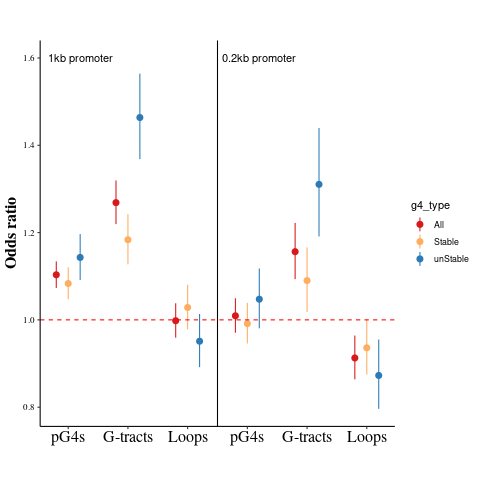

In [3]:
%%R
########################## merge 2504 1kGP ###########################
######################fixed
promoter_g4_fisher <- fisher.test(cbind(c(promoter[promoter$fileName=="promoter_pG4.merge.SFS",]$ployNumber, 
                                          promoter[promoter$fileName=="promoter_pG4.merge.SFS",]$subsNumber),
                                        c(promoter[promoter$fileName=="promoter_nonpG4.merge.SFS",]$ployNumber, 
                                          promoter[promoter$fileName=="promoter_nonpG4.merge.SFS",]$subsNumber)
                                       ))
promoter_Stable_g4_fisher <- fisher.test(cbind(c(promoter[promoter$fileName=="promoter_pG4_Stable.merge.SFS",]$ployNumber, 
                                          promoter[promoter$fileName=="promoter_pG4_Stable.merge.SFS",]$subsNumber),
                                        c(promoter[promoter$fileName=="promoter_nonpG4.merge.SFS",]$ployNumber, 
                                          promoter[promoter$fileName=="promoter_nonpG4.merge.SFS",]$subsNumber)
                                       ))
promoter_unStable_g4_fisher <- fisher.test(cbind(c(promoter[promoter$fileName=="promoter_pG4_unStable.merge.SFS",]$ployNumber, 
                                          promoter[promoter$fileName=="promoter_pG4_unStable.merge.SFS",]$subsNumber),
                                        c(promoter[promoter$fileName=="promoter_nonpG4.merge.SFS",]$ployNumber, 
                                          promoter[promoter$fileName=="promoter_nonpG4.merge.SFS",]$subsNumber)
                                       ))
promoter_gtract_fisher <- fisher.test(cbind(c(promoter[promoter$fileName=="promoter_pG4_Gtract.merge.SFS",]$ployNumber, 
                                          promoter[promoter$fileName=="promoter_pG4_Gtract.merge.SFS",]$subsNumber),
                                        c(promoter[promoter$fileName=="promoter_nonpG4.merge.SFS",]$ployNumber, 
                                          promoter[promoter$fileName=="promoter_nonpG4.merge.SFS",]$subsNumber)
                                       ))
promoter_Stable_gtract_fisher <- fisher.test(cbind(c(promoter[promoter$fileName=="promoter_stableG4_Gtract.merge.SFS",]$ployNumber, 
                                          promoter[promoter$fileName=="promoter_stableG4_Gtract.merge.SFS",]$subsNumber),
                                        c(promoter[promoter$fileName=="promoter_nonpG4.merge.SFS",]$ployNumber, 
                                          promoter[promoter$fileName=="promoter_nonpG4.merge.SFS",]$subsNumber)
                                       ))
promoter_unStable_gtract_fisher <- fisher.test(cbind(c(promoter[promoter$fileName=="promoter_unstable_Gtracts.merge.SFS",]$ployNumber, 
                                          promoter[promoter$fileName=="promoter_unstable_Gtracts.merge.SFS",]$subsNumber),
                                        c(promoter[promoter$fileName=="promoter_nonpG4.merge.SFS",]$ployNumber, 
                                          promoter[promoter$fileName=="promoter_nonpG4.merge.SFS",]$subsNumber)
                                       ))
# loop
promoter_loop_fisher <- fisher.test(cbind(c(promoter[promoter$fileName=="promoter_pG4.loop.merge.SFS",]$ployNumber, 
                                          promoter[promoter$fileName=="promoter_pG4.loop.merge.SFS",]$subsNumber),
                                        c(promoter[promoter$fileName=="promoter_nonpG4.merge.SFS",]$ployNumber, 
                                          promoter[promoter$fileName=="promoter_nonpG4.merge.SFS",]$subsNumber)
                                       ))
promoter_Stable_loop_fisher <- fisher.test(cbind(c(promoter[promoter$fileName=="promoter_pG4_Stable.loop.merge.SFS",]$ployNumber, 
                                          promoter[promoter$fileName=="promoter_pG4_Stable.loop.merge.SFS",]$subsNumber),
                                        c(promoter[promoter$fileName=="promoter_nonpG4.merge.SFS",]$ployNumber, 
                                          promoter[promoter$fileName=="promoter_nonpG4.merge.SFS",]$subsNumber)
                                       ))
promoter_unStable_loop_fisher <- fisher.test(cbind(c(promoter[promoter$fileName=="promoter_pG4_unStable.loop.merge.SFS",]$ployNumber, 
                                          promoter[promoter$fileName=="promoter_pG4_unStable.loop.merge.SFS",]$subsNumber),
                                        c(promoter[promoter$fileName=="promoter_nonpG4.merge.SFS",]$ployNumber, 
                                          promoter[promoter$fileName=="promoter_nonpG4.merge.SFS",]$subsNumber)
                                       ))

### active promoter ####
active_promoter_g4_fisher <- fisher.test(cbind(c(active_promoter[active_promoter$fileName=="active_promoter_pG4.merge.SFS",]$ployNumber, 
                                          active_promoter[active_promoter$fileName=="active_promoter_pG4.merge.SFS",]$subsNumber),
                                        c(active_promoter[active_promoter$fileName=="active_promoter_nonpG4.merge.SFS",]$ployNumber, 
                                          active_promoter[active_promoter$fileName=="active_promoter_nonpG4.merge.SFS",]$subsNumber)
                                       ))
active_promoter_Stable_g4_fisher <- fisher.test(cbind(c(active_promoter[active_promoter$fileName=="active_promoter_pG4_Stable.merge.SFS",]$ployNumber, 
                                          active_promoter[active_promoter$fileName=="active_promoter_pG4_Stable.merge.SFS",]$subsNumber),
                                        c(active_promoter[active_promoter$fileName=="active_promoter_nonpG4.merge.SFS",]$ployNumber, 
                                          active_promoter[active_promoter$fileName=="active_promoter_nonpG4.merge.SFS",]$subsNumber)
                                       ))
active_promoter_unStable_g4_fisher <- fisher.test(cbind(c(active_promoter[active_promoter$fileName=="active_promoter_pG4_unStable.merge.SFS",]$ployNumber, 
                                          active_promoter[active_promoter$fileName=="active_promoter_pG4_unStable.merge.SFS",]$subsNumber),
                                        c(active_promoter[active_promoter$fileName=="active_promoter_nonpG4.merge.SFS",]$ployNumber, 
                                          active_promoter[active_promoter$fileName=="active_promoter_nonpG4.merge.SFS",]$subsNumber)
                                       ))

active_promoter_gtract_fisher <- fisher.test(cbind(c(active_promoter[active_promoter$fileName=="active_promoter_pG4_Gtract.merge.SFS",]$ployNumber, 
                                          active_promoter[active_promoter$fileName=="active_promoter_pG4_Gtract.merge.SFS",]$subsNumber),
                                        c(active_promoter[active_promoter$fileName=="active_promoter_nonpG4.merge.SFS",]$ployNumber, 
                                          active_promoter[active_promoter$fileName=="active_promoter_nonpG4.merge.SFS",]$subsNumber)
                                       ))
active_promoter_Stable_gtract_fisher <- fisher.test(cbind(c(active_promoter[active_promoter$fileName=="active_promoter_stableG4_Gtract.merge.SFS",]$ployNumber, 
                                          active_promoter[active_promoter$fileName=="active_promoter_stableG4_Gtract.merge.SFS",]$subsNumber),
                                        c(active_promoter[active_promoter$fileName=="active_promoter_nonpG4.merge.SFS",]$ployNumber, 
                                          active_promoter[active_promoter$fileName=="active_promoter_nonpG4.merge.SFS",]$subsNumber)
                                       ))
active_promoter_unStable_gtract_fisher <- fisher.test(cbind(c(active_promoter[active_promoter$fileName=="active_promoter_unstable_Gtracts.merge.SFS",]$ployNumber, 
                                          active_promoter[active_promoter$fileName=="active_promoter_unstable_Gtracts.merge.SFS",]$subsNumber),
                                        c(active_promoter[active_promoter$fileName=="active_promoter_nonpG4.merge.SFS",]$ployNumber, 
                                          active_promoter[active_promoter$fileName=="active_promoter_nonpG4.merge.SFS",]$subsNumber)
                                       ))

## loop
active_promoter_loop_fisher <- fisher.test(cbind(c(active_promoter[active_promoter$fileName=="active_promoter_pG4.loop.merge.SFS",]$ployNumber, 
                                          active_promoter[active_promoter$fileName=="active_promoter_pG4.loop.merge.SFS",]$subsNumber),
                                        c(active_promoter[active_promoter$fileName=="active_promoter_nonpG4.merge.SFS",]$ployNumber, 
                                          active_promoter[active_promoter$fileName=="active_promoter_nonpG4.merge.SFS",]$subsNumber)
                                       ))
active_promoter_Stable_loop_fisher <- fisher.test(cbind(c(active_promoter[active_promoter$fileName=="active_promoter_pG4_Stable.loop.merge.SFS",]$ployNumber, 
                                          active_promoter[active_promoter$fileName=="active_promoter_pG4_Stable.loop.merge.SFS",]$subsNumber),
                                        c(active_promoter[active_promoter$fileName=="active_promoter_nonpG4.merge.SFS",]$ployNumber, 
                                          active_promoter[active_promoter$fileName=="active_promoter_nonpG4.merge.SFS",]$subsNumber)
                                       ))
active_promoter_unStable_loop_fisher <- fisher.test(cbind(c(active_promoter[active_promoter$fileName=="active_promoter_pG4_unStable.loop.merge.SFS",]$ployNumber, 
                                          active_promoter[active_promoter$fileName=="active_promoter_pG4_unStable.loop.merge.SFS",]$subsNumber),
                                        c(active_promoter[active_promoter$fileName=="active_promoter_nonpG4.merge.SFS",]$ployNumber, 
                                          active_promoter[active_promoter$fileName=="active_promoter_nonpG4.merge.SFS",]$subsNumber)
                                       ))




promoter_G4 <- c("Promoter", "pG4", "All", promoter_g4_fisher$estimate, promoter_g4_fisher$conf.int[1],promoter_g4_fisher$conf.int[2], promoter_g4_fisher$p.value)
promoter_Stable_G4 <- c("Promoter", "pG4", "Stable", promoter_Stable_g4_fisher$estimate, promoter_Stable_g4_fisher$conf.int[1],promoter_Stable_g4_fisher$conf.int[2], promoter_Stable_g4_fisher$p.value)
promoter_unStable_G4 <- c("Promoter", "pG4", "unStable", promoter_unStable_g4_fisher$estimate, promoter_unStable_g4_fisher$conf.int[1],promoter_unStable_g4_fisher$conf.int[2], promoter_unStable_g4_fisher$p.value)

active_promoter_G4 <- c("active_promoter", "pG4", "All", active_promoter_g4_fisher$estimate, active_promoter_g4_fisher$conf.int[1],active_promoter_g4_fisher$conf.int[2], active_promoter_g4_fisher$p.value)
active_promoter_Stable_G4 <- c("active_promoter", "pG4", "Stable", active_promoter_Stable_g4_fisher$estimate, active_promoter_Stable_g4_fisher$conf.int[1],active_promoter_Stable_g4_fisher$conf.int[2], active_promoter_Stable_g4_fisher$p.value)
active_promoter_unStable_G4 <- c("active_promoter", "pG4", "unStable", active_promoter_unStable_g4_fisher$estimate, active_promoter_unStable_g4_fisher$conf.int[1],active_promoter_unStable_g4_fisher$conf.int[2], active_promoter_unStable_g4_fisher$p.value)

promoter_Gtract <- c("Promoter", "Gtract", "All", promoter_gtract_fisher$estimate, promoter_gtract_fisher$conf.int[1],promoter_gtract_fisher$conf.int[2], promoter_gtract_fisher$p.value)
promoter_Stable_Gtract <- c("Promoter", "Gtract", "Stable", promoter_Stable_gtract_fisher$estimate, promoter_Stable_gtract_fisher$conf.int[1],promoter_Stable_gtract_fisher$conf.int[2], promoter_Stable_gtract_fisher$p.value)
promoter_unStable_Gtract <- c("Promoter", "Gtract", "unStable", promoter_unStable_gtract_fisher$estimate, promoter_unStable_gtract_fisher$conf.int[1],promoter_unStable_gtract_fisher$conf.int[2], promoter_unStable_gtract_fisher$p.value)

active_promoter_Gtract <- c("active_promoter", "Gtract", "All", active_promoter_gtract_fisher$estimate, active_promoter_gtract_fisher$conf.int[1],active_promoter_gtract_fisher$conf.int[2], active_promoter_gtract_fisher$p.value)
active_promoter_Stable_Gtract <- c("active_promoter", "Gtract", "Stable", active_promoter_Stable_gtract_fisher$estimate, active_promoter_Stable_gtract_fisher$conf.int[1],active_promoter_Stable_gtract_fisher$conf.int[2], active_promoter_Stable_gtract_fisher$p.value)
active_promoter_unStable_Gtract <- c("active_promoter", "Gtract", "unStable", active_promoter_unStable_gtract_fisher$estimate, active_promoter_unStable_gtract_fisher$conf.int[1],active_promoter_unStable_gtract_fisher$conf.int[2], active_promoter_unStable_gtract_fisher$p.value)
## loop 
promoter_loop <- c("Promoter", "loop", "All", promoter_loop_fisher$estimate, promoter_loop_fisher$conf.int[1],promoter_loop_fisher$conf.int[2], promoter_loop_fisher$p.value)
promoter_Stable_loop <- c("Promoter", "loop", "Stable", promoter_Stable_loop_fisher$estimate, promoter_Stable_loop_fisher$conf.int[1],promoter_Stable_loop_fisher$conf.int[2], promoter_Stable_loop_fisher$p.value)
promoter_unStable_loop <- c("Promoter", "loop", "unStable", promoter_unStable_loop_fisher$estimate, promoter_unStable_loop_fisher$conf.int[1],promoter_unStable_loop_fisher$conf.int[2], promoter_unStable_loop_fisher$p.value)

active_promoter_loop <- c("active_promoter", "loop", "All", active_promoter_loop_fisher$estimate, active_promoter_loop_fisher$conf.int[1],active_promoter_loop_fisher$conf.int[2], active_promoter_loop_fisher$p.value)
active_promoter_Stable_loop <- c("active_promoter", "loop", "Stable", active_promoter_Stable_loop_fisher$estimate, active_promoter_Stable_loop_fisher$conf.int[1],active_promoter_Stable_loop_fisher$conf.int[2], active_promoter_Stable_loop_fisher$p.value)
active_promoter_unStable_loop <- c("active_promoter", "loop", "unStable", active_promoter_unStable_loop_fisher$estimate, active_promoter_unStable_loop_fisher$conf.int[1],active_promoter_unStable_loop_fisher$conf.int[2], active_promoter_unStable_loop_fisher$p.value)

df <- t(data.frame(promoter_G4,promoter_Stable_G4,promoter_unStable_G4,
                   promoter_Gtract, promoter_Stable_Gtract, promoter_unStable_Gtract,
                   promoter_loop, promoter_Stable_loop, promoter_unStable_loop,
                   active_promoter_G4,active_promoter_Stable_G4,active_promoter_unStable_G4,
                   active_promoter_Gtract, active_promoter_Stable_Gtract, active_promoter_unStable_Gtract,
                   active_promoter_loop, active_promoter_Stable_loop, active_promoter_unStable_loop
                   ))

colnames(df) <- c("promoter_type", "groups", "g4_type","OR","OR_down","OR_up", "pvalue")
write.table(df, "kg_merge.fisher.reslt.tsv", sep="\t", quote = F,row.names=F)
library(ggplot2)
library(tidyr)
df = as.data.frame(df)
df$OR <- as.numeric(df$OR)
df$OR_down <- as.numeric(df$OR_down)
df$OR_up <- as.numeric(df$OR_up)

df$x=c(0.8,1,1.2,1.8,2,2.2,2.8,3,3.2,
       3.8,4,4.2,4.8,5,5.2,5.8,6,6.2
      )

cols <-c(All="#d7191c",Stable="#fdae61",unStable="#2c7bb6")
g <- ggplot(df,aes(x=x,y=OR, color=g4_type))+geom_point()+
    geom_pointrange(aes(ymin=OR_down, ymax=OR_up))+
    geom_hline(yintercept=1.0, linetype="dashed", color="red")+
    scale_fill_manual(values=cols)+
    scale_color_manual(values=cols)+
    geom_vline(xintercept = 3.5, color = "black")+
    labs(title="",subtitle="",y="Odds ratio",x="",caption="",size=16)+
    scale_x_continuous(breaks=c(1,2,3,4,5,6),
                      labels=c("pG4s", "G-tracts","Loops","pG4s", "G-tracts","Loops")
                      )+
    annotate("text",x=4.2,y=1.6,label="0.2kb promoter")+
    annotate("text",x=1.2,y=1.6,label="1kb promoter")+
    theme_classic()+
    theme(axis.text.x=element_text(family = "Times",size=16, colour ="black"),
          axis.text.y = element_text(family = "Times", size=9, colour="black"),
          axis.title.y = element_text(family = "Times", size=16, colour="black",face="bold")
         )
# ggsave("kg_merge.fisher.HKA.pdf",g)
g

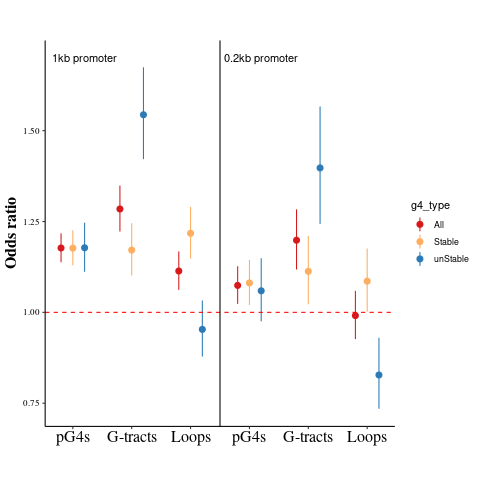

In [4]:
%%R
########################## EUR 503 samples 1kGP ###########################
promoter_g4_fisher <- fisher.test(cbind(c(promoter[promoter$fileName=="promoter_pG4.EUR.SFS",]$ployNumber, 
                                          promoter[promoter$fileName=="promoter_pG4.EUR.SFS",]$subsNumber),
                                        c(promoter[promoter$fileName=="promoter_nonpG4.EUR.SFS",]$ployNumber, 
                                          promoter[promoter$fileName=="promoter_nonpG4.EUR.SFS",]$subsNumber)
                                       ))
promoter_Stable_g4_fisher <- fisher.test(cbind(c(promoter[promoter$fileName=="promoter_pG4_Stable.EUR.SFS",]$ployNumber, 
                                          promoter[promoter$fileName=="promoter_pG4_Stable.EUR.SFS",]$subsNumber),
                                        c(promoter[promoter$fileName=="promoter_nonpG4.EUR.SFS",]$ployNumber, 
                                          promoter[promoter$fileName=="promoter_nonpG4.EUR.SFS",]$subsNumber)
                                       ))
promoter_unStable_g4_fisher <- fisher.test(cbind(c(promoter[promoter$fileName=="promoter_pG4_unStable.EUR.SFS",]$ployNumber, 
                                          promoter[promoter$fileName=="promoter_pG4_unStable.EUR.SFS",]$subsNumber),
                                        c(promoter[promoter$fileName=="promoter_nonpG4.EUR.SFS",]$ployNumber, 
                                          promoter[promoter$fileName=="promoter_nonpG4.EUR.SFS",]$subsNumber)
                                       ))
promoter_gtract_fisher <- fisher.test(cbind(c(promoter[promoter$fileName=="promoter_pG4_Gtract.EUR.SFS",]$ployNumber, 
                                          promoter[promoter$fileName=="promoter_pG4_Gtract.EUR.SFS",]$subsNumber),
                                        c(promoter[promoter$fileName=="promoter_nonpG4.EUR.SFS",]$ployNumber, 
                                          promoter[promoter$fileName=="promoter_nonpG4.EUR.SFS",]$subsNumber)
                                       ))
promoter_Stable_gtract_fisher <- fisher.test(cbind(c(promoter[promoter$fileName=="promoter_stableG4_Gtract.EUR.SFS",]$ployNumber, 
                                          promoter[promoter$fileName=="promoter_stableG4_Gtract.EUR.SFS",]$subsNumber),
                                        c(promoter[promoter$fileName=="promoter_nonpG4.EUR.SFS",]$ployNumber, 
                                          promoter[promoter$fileName=="promoter_nonpG4.EUR.SFS",]$subsNumber)
                                       ))
promoter_unStable_gtract_fisher <- fisher.test(cbind(c(promoter[promoter$fileName=="promoter_unstable_Gtracts.EUR.SFS",]$ployNumber, 
                                          promoter[promoter$fileName=="promoter_unstable_Gtracts.EUR.SFS",]$subsNumber),
                                        c(promoter[promoter$fileName=="promoter_nonpG4.EUR.SFS",]$ployNumber, 
                                          promoter[promoter$fileName=="promoter_nonpG4.EUR.SFS",]$subsNumber)
                                       ))
# loop
promoter_loop_fisher <- fisher.test(cbind(c(promoter[promoter$fileName=="promoter_pG4.loop.EUR.SFS",]$ployNumber, 
                                          promoter[promoter$fileName=="promoter_pG4.loop.EUR.SFS",]$subsNumber),
                                        c(promoter[promoter$fileName=="promoter_nonpG4.EUR.SFS",]$ployNumber, 
                                          promoter[promoter$fileName=="promoter_nonpG4.EUR.SFS",]$subsNumber)
                                       ))
promoter_Stable_loop_fisher <- fisher.test(cbind(c(promoter[promoter$fileName=="promoter_pG4_Stable.loop.EUR.SFS",]$ployNumber, 
                                          promoter[promoter$fileName=="promoter_pG4_Stable.loop.EUR.SFS",]$subsNumber),
                                        c(promoter[promoter$fileName=="promoter_nonpG4.EUR.SFS",]$ployNumber, 
                                          promoter[promoter$fileName=="promoter_nonpG4.EUR.SFS",]$subsNumber)
                                       ))
promoter_unStable_loop_fisher <- fisher.test(cbind(c(promoter[promoter$fileName=="promoter_pG4_unStable.loop.EUR.SFS",]$ployNumber, 
                                          promoter[promoter$fileName=="promoter_pG4_unStable.loop.EUR.SFS",]$subsNumber),
                                        c(promoter[promoter$fileName=="promoter_nonpG4.EUR.SFS",]$ployNumber, 
                                          promoter[promoter$fileName=="promoter_nonpG4.EUR.SFS",]$subsNumber)
                                       ))

### active promoter ####
active_promoter_g4_fisher <- fisher.test(cbind(c(active_promoter[active_promoter$fileName=="active_promoter_pG4.EUR.SFS",]$ployNumber, 
                                          active_promoter[active_promoter$fileName=="active_promoter_pG4.EUR.SFS",]$subsNumber),
                                        c(active_promoter[active_promoter$fileName=="active_promoter_nonpG4.EUR.SFS",]$ployNumber, 
                                          active_promoter[active_promoter$fileName=="active_promoter_nonpG4.EUR.SFS",]$subsNumber)
                                       ))
active_promoter_Stable_g4_fisher <- fisher.test(cbind(c(active_promoter[active_promoter$fileName=="active_promoter_pG4_Stable.EUR.SFS",]$ployNumber, 
                                          active_promoter[active_promoter$fileName=="active_promoter_pG4_Stable.EUR.SFS",]$subsNumber),
                                        c(active_promoter[active_promoter$fileName=="active_promoter_nonpG4.EUR.SFS",]$ployNumber, 
                                          active_promoter[active_promoter$fileName=="active_promoter_nonpG4.EUR.SFS",]$subsNumber)
                                       ))
active_promoter_unStable_g4_fisher <- fisher.test(cbind(c(active_promoter[active_promoter$fileName=="active_promoter_pG4_unStable.EUR.SFS",]$ployNumber, 
                                          active_promoter[active_promoter$fileName=="active_promoter_pG4_unStable.EUR.SFS",]$subsNumber),
                                        c(active_promoter[active_promoter$fileName=="active_promoter_nonpG4.EUR.SFS",]$ployNumber, 
                                          active_promoter[active_promoter$fileName=="active_promoter_nonpG4.EUR.SFS",]$subsNumber)
                                       ))

active_promoter_gtract_fisher <- fisher.test(cbind(c(active_promoter[active_promoter$fileName=="active_promoter_pG4_Gtract.EUR.SFS",]$ployNumber, 
                                          active_promoter[active_promoter$fileName=="active_promoter_pG4_Gtract.EUR.SFS",]$subsNumber),
                                        c(active_promoter[active_promoter$fileName=="active_promoter_nonpG4.EUR.SFS",]$ployNumber, 
                                          active_promoter[active_promoter$fileName=="active_promoter_nonpG4.EUR.SFS",]$subsNumber)
                                       ))
active_promoter_Stable_gtract_fisher <- fisher.test(cbind(c(active_promoter[active_promoter$fileName=="active_promoter_stableG4_Gtract.EUR.SFS",]$ployNumber, 
                                          active_promoter[active_promoter$fileName=="active_promoter_stableG4_Gtract.EUR.SFS",]$subsNumber),
                                        c(active_promoter[active_promoter$fileName=="active_promoter_nonpG4.EUR.SFS",]$ployNumber, 
                                          active_promoter[active_promoter$fileName=="active_promoter_nonpG4.EUR.SFS",]$subsNumber)
                                       ))
active_promoter_unStable_gtract_fisher <- fisher.test(cbind(c(active_promoter[active_promoter$fileName=="active_promoter_unstable_Gtracts.EUR.SFS",]$ployNumber, 
                                          active_promoter[active_promoter$fileName=="active_promoter_unstable_Gtracts.EUR.SFS",]$subsNumber),
                                        c(active_promoter[active_promoter$fileName=="active_promoter_nonpG4.EUR.SFS",]$ployNumber, 
                                          active_promoter[active_promoter$fileName=="active_promoter_nonpG4.EUR.SFS",]$subsNumber)
                                       ))

## loop
active_promoter_loop_fisher <- fisher.test(cbind(c(active_promoter[active_promoter$fileName=="active_promoter_pG4.loop.EUR.SFS",]$ployNumber, 
                                          active_promoter[active_promoter$fileName=="active_promoter_pG4.loop.EUR.SFS",]$subsNumber),
                                        c(active_promoter[active_promoter$fileName=="active_promoter_nonpG4.EUR.SFS",]$ployNumber, 
                                          active_promoter[active_promoter$fileName=="active_promoter_nonpG4.EUR.SFS",]$subsNumber)
                                       ))
active_promoter_Stable_loop_fisher <- fisher.test(cbind(c(active_promoter[active_promoter$fileName=="active_promoter_pG4_Stable.loop.EUR.SFS",]$ployNumber, 
                                          active_promoter[active_promoter$fileName=="active_promoter_pG4_Stable.loop.EUR.SFS",]$subsNumber),
                                        c(active_promoter[active_promoter$fileName=="active_promoter_nonpG4.EUR.SFS",]$ployNumber, 
                                          active_promoter[active_promoter$fileName=="active_promoter_nonpG4.EUR.SFS",]$subsNumber)
                                       ))
active_promoter_unStable_loop_fisher <- fisher.test(cbind(c(active_promoter[active_promoter$fileName=="active_promoter_pG4_unStable.loop.EUR.SFS",]$ployNumber, 
                                          active_promoter[active_promoter$fileName=="active_promoter_pG4_unStable.loop.EUR.SFS",]$subsNumber),
                                        c(active_promoter[active_promoter$fileName=="active_promoter_nonpG4.EUR.SFS",]$ployNumber, 
                                          active_promoter[active_promoter$fileName=="active_promoter_nonpG4.EUR.SFS",]$subsNumber)
                                       ))




promoter_G4 <- c("Promoter", "pG4", "All", promoter_g4_fisher$estimate, promoter_g4_fisher$conf.int[1],promoter_g4_fisher$conf.int[2], promoter_g4_fisher$p.value)
promoter_Stable_G4 <- c("Promoter", "pG4", "Stable", promoter_Stable_g4_fisher$estimate, promoter_Stable_g4_fisher$conf.int[1],promoter_Stable_g4_fisher$conf.int[2], promoter_Stable_g4_fisher$p.value)
promoter_unStable_G4 <- c("Promoter", "pG4", "unStable", promoter_unStable_g4_fisher$estimate, promoter_unStable_g4_fisher$conf.int[1],promoter_unStable_g4_fisher$conf.int[2], promoter_unStable_g4_fisher$p.value)

active_promoter_G4 <- c("active_promoter", "pG4", "All", active_promoter_g4_fisher$estimate, active_promoter_g4_fisher$conf.int[1],active_promoter_g4_fisher$conf.int[2], active_promoter_g4_fisher$p.value)
active_promoter_Stable_G4 <- c("active_promoter", "pG4", "Stable", active_promoter_Stable_g4_fisher$estimate, active_promoter_Stable_g4_fisher$conf.int[1],active_promoter_Stable_g4_fisher$conf.int[2], active_promoter_Stable_g4_fisher$p.value)
active_promoter_unStable_G4 <- c("active_promoter", "pG4", "unStable", active_promoter_unStable_g4_fisher$estimate, active_promoter_unStable_g4_fisher$conf.int[1],active_promoter_unStable_g4_fisher$conf.int[2], active_promoter_unStable_g4_fisher$p.value)

promoter_Gtract <- c("Promoter", "Gtract", "All", promoter_gtract_fisher$estimate, promoter_gtract_fisher$conf.int[1],promoter_gtract_fisher$conf.int[2], promoter_gtract_fisher$p.value)
promoter_Stable_Gtract <- c("Promoter", "Gtract", "Stable", promoter_Stable_gtract_fisher$estimate, promoter_Stable_gtract_fisher$conf.int[1],promoter_Stable_gtract_fisher$conf.int[2], promoter_Stable_gtract_fisher$p.value)
promoter_unStable_Gtract <- c("Promoter", "Gtract", "unStable", promoter_unStable_gtract_fisher$estimate, promoter_unStable_gtract_fisher$conf.int[1],promoter_unStable_gtract_fisher$conf.int[2], promoter_unStable_gtract_fisher$p.value)

active_promoter_Gtract <- c("active_promoter", "Gtract", "All", active_promoter_gtract_fisher$estimate, active_promoter_gtract_fisher$conf.int[1],active_promoter_gtract_fisher$conf.int[2], active_promoter_gtract_fisher$p.value)
active_promoter_Stable_Gtract <- c("active_promoter", "Gtract", "Stable", active_promoter_Stable_gtract_fisher$estimate, active_promoter_Stable_gtract_fisher$conf.int[1],active_promoter_Stable_gtract_fisher$conf.int[2], active_promoter_Stable_gtract_fisher$p.value)
active_promoter_unStable_Gtract <- c("active_promoter", "Gtract", "unStable", active_promoter_unStable_gtract_fisher$estimate, active_promoter_unStable_gtract_fisher$conf.int[1],active_promoter_unStable_gtract_fisher$conf.int[2], active_promoter_unStable_gtract_fisher$p.value)
## loop 
promoter_loop <- c("Promoter", "loop", "All", promoter_loop_fisher$estimate, promoter_loop_fisher$conf.int[1],promoter_loop_fisher$conf.int[2], promoter_loop_fisher$p.value)
promoter_Stable_loop <- c("Promoter", "loop", "Stable", promoter_Stable_loop_fisher$estimate, promoter_Stable_loop_fisher$conf.int[1],promoter_Stable_loop_fisher$conf.int[2], promoter_Stable_loop_fisher$p.value)
promoter_unStable_loop <- c("Promoter", "loop", "unStable", promoter_unStable_loop_fisher$estimate, promoter_unStable_loop_fisher$conf.int[1],promoter_unStable_loop_fisher$conf.int[2], promoter_unStable_loop_fisher$p.value)

active_promoter_loop <- c("active_promoter", "loop", "All", active_promoter_loop_fisher$estimate, active_promoter_loop_fisher$conf.int[1],active_promoter_loop_fisher$conf.int[2], active_promoter_loop_fisher$p.value)
active_promoter_Stable_loop <- c("active_promoter", "loop", "Stable", active_promoter_Stable_loop_fisher$estimate, active_promoter_Stable_loop_fisher$conf.int[1],active_promoter_Stable_loop_fisher$conf.int[2], active_promoter_Stable_loop_fisher$p.value)
active_promoter_unStable_loop <- c("active_promoter", "loop", "unStable", active_promoter_unStable_loop_fisher$estimate, active_promoter_unStable_loop_fisher$conf.int[1],active_promoter_unStable_loop_fisher$conf.int[2], active_promoter_unStable_loop_fisher$p.value)

df <- t(data.frame(
                   promoter_G4,promoter_Stable_G4,promoter_unStable_G4,
                   promoter_Gtract, promoter_Stable_Gtract, promoter_unStable_Gtract,
                   promoter_loop, promoter_Stable_loop, promoter_unStable_loop,
                   active_promoter_G4,active_promoter_Stable_G4,active_promoter_unStable_G4, 
                   active_promoter_Gtract, active_promoter_Stable_Gtract, active_promoter_unStable_Gtract,
                   active_promoter_loop, active_promoter_Stable_loop, active_promoter_unStable_loop
                   ))
colnames(df) <- c("promoter_type", "groups", "g4_type","OR","OR_down","OR_up", "pvalue")
write.table(df, "kg_EUR.fisher.reslt.tsv", quote = F,sep="\t", row.names=F)
library(ggplot2)
library(tidyr)
df = as.data.frame(df)
df$OR <- as.numeric(df$OR)
df$OR_down <- as.numeric(df$OR_down)
df$OR_up <- as.numeric(df$OR_up)

df$x=c(0.8,1,1.2,1.8,2,2.2,2.8,3,3.2,
       3.8,4,4.2,4.8,5,5.2,5.8,6,6.2
      )

cols <-c(All="#d7191c",Stable="#fdae61",unStable="#2c7bb6")
g <- ggplot(df,aes(x=x,y=OR, color=g4_type))+geom_point()+
    geom_pointrange(aes(ymin=OR_down, ymax=OR_up))+
    geom_hline(yintercept=1.0, linetype="dashed", color="red")+
    scale_fill_manual(values=cols)+
    scale_color_manual(values=cols)+
#     geom_vline(xintercept = 2.5, color = "black")+
    geom_vline(xintercept = 3.5, color = "black")+
    labs(title="",subtitle="",y="Odds ratio",x="",caption="",size=16)+
    scale_x_continuous(breaks=c(1,2,3,4,5,6),labels=c("pG4s", "G-tracts","Loops", "pG4s", "G-tracts","Loops"))+
    theme_classic()+
    annotate("text",x=4.2,y=1.7,label="0.2kb promoter")+
    annotate("text",x=1.2,y=1.7,label="1kb promoter")+
    theme(axis.text.x=element_text(family = "Times",size=16,  colour ="black"),
          axis.text.y = element_text(family = "Times", size=9, colour="black"),
          axis.title.y = element_text(family = "Times", size=16, colour="black",face="bold")
         )
# ggsave("kg_EUR.fisher.HKA.pdf",g)
g

In [5]:
# EUR pG4 503
import os
from scipy import stats

def maf_get(inputfile,populationNumber):
    min_fre = 1/int(populationNumber)
    with open(inputfile,'r')as fr:
        mafs = []
        selectkey_parser = set()
        for line in fr:
            uline = line.strip().split("\t")
            key = "|".join(uline[0:3])
            sfs = uline[3]
            maf = sfs.split("|")[4]
            
            if key not in selectkey_parser and maf != "NA":
                if float(maf) < 1:
                    maf = float(maf)
                    if maf > 0.5:
                        maf = 1 - maf
                    if float(maf) > min_fre:
                        mafs.append(maf)
            selectkey_parser.add(key)
    return mafs


def KS_test(test, control, comparedName):
    ks_result = stats.ks_2samp(test,control)
    print(comparedName)
    print("Asymptotic two-sample Kolmogorov-Smirnov test")
    print("D = ",ks_result[0])
    print("p-value = ",ks_result[1])
    print("**********")

WD_path = "/disk2/G4_MS/frequency/HKA"

promoter_Stable_pG4_path = os.path.join(WD_path,"promoter_pG4_Stable.EUR.SFS")
promoter_unStable_pG4_path = os.path.join(WD_path,"promoter_pG4_unStable.EUR.SFS")
promoter_pG4_control_path = os.path.join(WD_path,"promoter_nonpG4.EUR.SFS")

activePromoter_Stable_pG4_path = os.path.join(WD_path,"active_promoter_pG4_Stable.EUR.SFS")
activePromoter_unStable_pG4_path = os.path.join(WD_path,"active_promoter_pG4_unStable.EUR.SFS")
activePromoter_pG4_control_path = os.path.join(WD_path,"active_promoter_nonpG4.EUR.SFS")


promoter_Stable_pG4 = maf_get(promoter_Stable_pG4_path, 503)
promoter_unStable_pG4 = maf_get(promoter_unStable_pG4_path, 503)
promoter_pG4_control = maf_get(promoter_pG4_control_path, 503)

activePromoter_Stable_pG4 = maf_get(activePromoter_Stable_pG4_path, 503)
activePromoter_unStable_pG4 = maf_get(activePromoter_unStable_pG4_path, 503)
activePromoter_pG4_control = maf_get(activePromoter_pG4_control_path, 503)
## Gtracts 
promoter_Stable_Gtracts_path = os.path.join(WD_path,"promoter_stableG4_Gtract.EUR.SFS")
promoter_unStable_Gtracts_path = os.path.join(WD_path,"promoter_unstable_Gtracts.EUR.SFS")
promoter_Stable_Gtracts = maf_get(promoter_Stable_Gtracts_path, 503)
promoter_unStable_Gtracts = maf_get(promoter_unStable_Gtracts_path, 503)

activePromoter_Stable_Gtracts_path = os.path.join(WD_path,"active_promoter_stableG4_Gtract.EUR.SFS")
activePromoter_unStable_Gtracts_path = os.path.join(WD_path,"active_promoter_unstable_Gtracts.EUR.SFS")
activePromoter_Stable_Gtracts = maf_get(activePromoter_Stable_Gtracts_path, 503)
activePromoter_unStable_Gtracts = maf_get(activePromoter_unStable_Gtracts_path, 503)
## loops
promoter_Stable_loops_path = os.path.join(WD_path,"promoter_pG4_Stable.loop.EUR.SFS")
promoter_unStable_loops_path = os.path.join(WD_path,"promoter_pG4_unStable.loop.EUR.SFS")
promoter_Stable_loops = maf_get(promoter_Stable_loops_path, 503)
promoter_unStable_loops = maf_get(promoter_unStable_loops_path, 503)

activePromoter_Stable_loops_path = os.path.join(WD_path,"active_promoter_pG4_Stable.loop.EUR.SFS")
activePromoter_unStable_loops_path = os.path.join(WD_path,"active_promoter_pG4_unStable.loop.EUR.SFS")
activePromoter_Stable_loops = maf_get(activePromoter_Stable_loops_path, 503)
activePromoter_unStable_loops = maf_get(activePromoter_unStable_loops_path, 503)

# ks tset
print("*"*20+"Promoter"+ "*"*20)

KS_test(promoter_Stable_pG4 + promoter_unStable_pG4 ,promoter_pG4_control,"all pG4")
KS_test(promoter_Stable_pG4,promoter_pG4_control,"Stable pG4")
KS_test(promoter_unStable_pG4,promoter_pG4_control,"unStable pG4")

KS_test(promoter_Stable_Gtracts + promoter_unStable_Gtracts ,promoter_pG4_control,"all pG4 G-tracts")
KS_test(promoter_Stable_Gtracts,promoter_pG4_control,"Stable pG4 G-tracts")
KS_test(promoter_unStable_Gtracts,promoter_pG4_control,"unStable pG4 G-tracts")

KS_test(promoter_Stable_loops + promoter_unStable_loops ,promoter_pG4_control,"all pG4 loops")
KS_test(promoter_Stable_loops,promoter_pG4_control,"Stable pG4 loops")
KS_test(promoter_unStable_loops,promoter_pG4_control,"unStable pG4 loops")

print("*"*20+"active Promoter"+ "*"*20)
KS_test(activePromoter_Stable_pG4 + activePromoter_unStable_pG4 ,activePromoter_pG4_control,"all pG4")
KS_test(activePromoter_Stable_pG4, activePromoter_pG4_control,"Stable pG4")
KS_test(activePromoter_unStable_pG4,activePromoter_pG4_control,"unStable pG4")

KS_test(activePromoter_Stable_Gtracts + activePromoter_unStable_Gtracts ,activePromoter_pG4_control,"all pG4 G-tracts")
KS_test(activePromoter_Stable_Gtracts,activePromoter_pG4_control,"Stable pG4 G-tracts")
KS_test(activePromoter_unStable_Gtracts,activePromoter_pG4_control,"unStable pG4 G-tracts")

KS_test(activePromoter_Stable_loops + activePromoter_unStable_loops ,activePromoter_pG4_control,"all pG4 loops")
KS_test(activePromoter_Stable_loops,activePromoter_pG4_control,"Stable pG4 loops")
KS_test(activePromoter_unStable_loops,activePromoter_pG4_control,"unStable pG4 loops")

********************Promoter********************
all pG4
Asymptotic two-sample Kolmogorov-Smirnov test
D =  0.12278162772445339
p-value =  5.27663293836081e-103
**********
Stable pG4
Asymptotic two-sample Kolmogorov-Smirnov test
D =  0.15017467063275902
p-value =  6.472068411720847e-111
**********
unStable pG4
Asymptotic two-sample Kolmogorov-Smirnov test
D =  0.05858377575284457
p-value =  8.527372846425907e-08
**********
all pG4 G-tracts
Asymptotic two-sample Kolmogorov-Smirnov test
D =  0.10705029717307768
p-value =  1.5016013802401027e-31
**********
Stable pG4 G-tracts
Asymptotic two-sample Kolmogorov-Smirnov test
D =  0.12290704042607015
p-value =  6.580998093561179e-28
**********
unStable pG4 G-tracts
Asymptotic two-sample Kolmogorov-Smirnov test
D =  0.08684940646980122
p-value =  1.6439662944136932e-07
**********
all pG4 loops
Asymptotic two-sample Kolmogorov-Smirnov test
D =  0.1215910147787288
p-value =  1.5814364519693104e-53
**********
Stable pG4 loops
Asymptotic two-sample

meta NOT subset; don't know how to subset; dropped


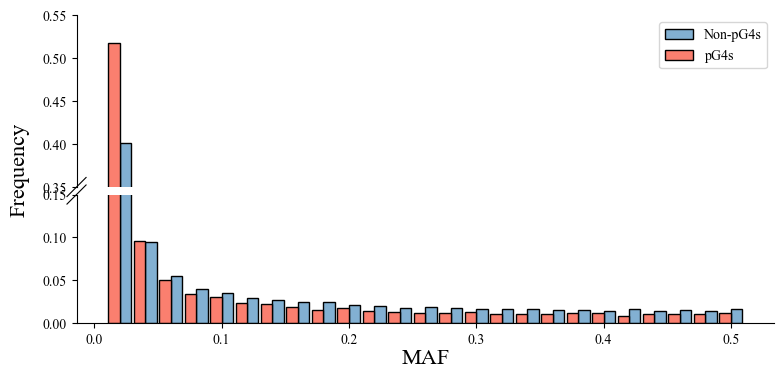

meta NOT subset; don't know how to subset; dropped


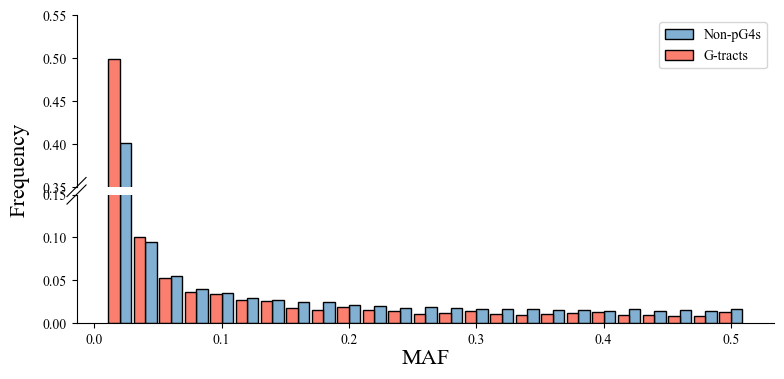

meta NOT subset; don't know how to subset; dropped


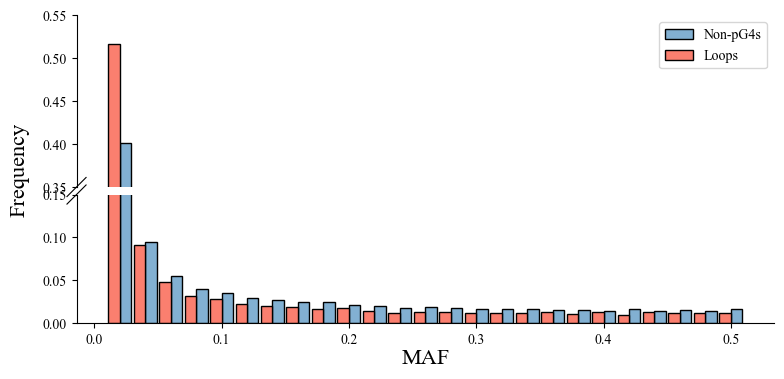

********************Active promoter ********************


meta NOT subset; don't know how to subset; dropped


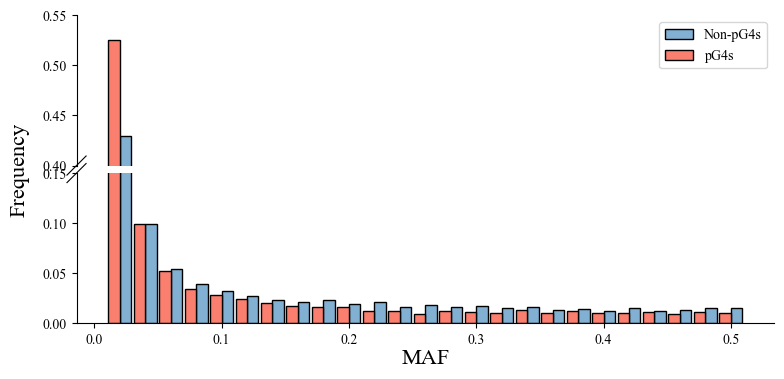

meta NOT subset; don't know how to subset; dropped


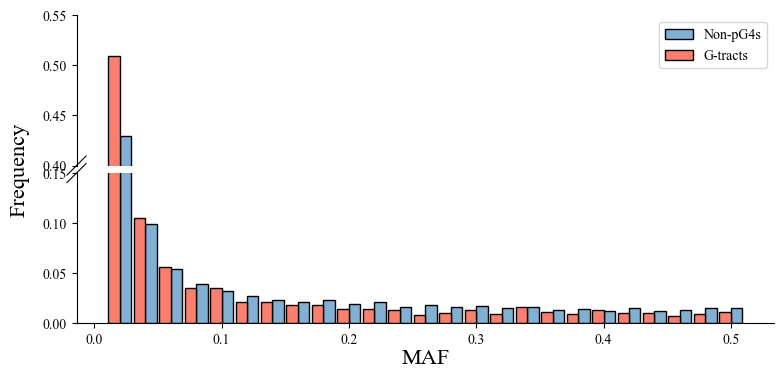

meta NOT subset; don't know how to subset; dropped


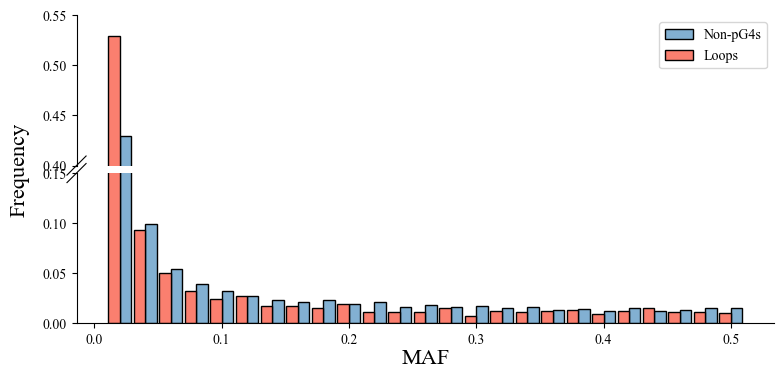

In [8]:
import pandas as pd
import os
import numpy as np
from brokenaxes import brokenaxes
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt

def bar_fig(df_c,df,groups,outputname,break_up=0.35):
    mpl.rcParams["pdf.fonttype"] = 42
    mpl.rcParams["ps.fonttype"] = 42
    plt.rcParams['font.sans-serif']=['Times New Roman']

    plt.figure(figsize=(9,4))
    total_width, n = 0.9, 100
    width = total_width/n
    bax = brokenaxes(ylims=((0,0.15),(break_up,0.55)),hspace=0.05)
    tmp_x = []
    tmp_x2 = []

    for _ in list(df_c["x"]):
        tmp_x2.append(_+width/2)
    bax.bar(tmp_x2,df_c["frequency"],width=width,label="Non-pG4s",alpha=1,edgecolor="black",fc="#82B0D2")
    for _ in list(df["x"]):
        tmp_x.append(_- width/2)
    bax.bar(tmp_x,df["frequency"],width=width,label=groups,alpha=1, edgecolor="black",fc="#FA7F6F")
    bax.legend(loc=1)

    bax.set_xlabel('MAF',size=16)
    bax.set_ylabel( "Frequency",size=16)
    plt.savefig(outputname)
    plt.show()
WD_path = "/disk2/G4_MS/frequency/HKA/MAF"
bins = np.arange(0,0.51,0.02)
### promoter
control_bins = pd.cut(promoter_pG4_control,bins,labels=np.delete(bins,[0]))
df_c = pd.DataFrame(pd.value_counts(control_bins)/len(control_bins), columns= ["frequency"])
df_c.loc[:,"groups"] = "non-pG4s"
df_c.loc[:,"x"] = df_c.index

# all pG4
bins_splited = pd.cut(promoter_Stable_pG4+promoter_unStable_pG4,bins,labels=np.delete(bins,[0]))
df = pd.DataFrame(pd.value_counts(bins_splited)/len(bins_splited), columns= ["frequency"])
df.loc[:,"groups"] = "pG4s"
df.loc[:,"x"] = df.index

bar_fig(df_c,df,"pG4s",os.path.join(WD_path,"promoter_pG4.maf.pdf"))
df = df.merge(df_c,on="x")
df = df.rename(columns={"frequency_x":"pG4s","frequency_y":"Non_pG4s","x":"MAF"})
df = df.loc[:,["MAF","Non_pG4s","pG4s"]]
df.to_csv(os.path.join(WD_path,"promoter_pG4.tsv.txt"),index=False, sep="\t")
# G-tracts
bins_splited = pd.cut(promoter_Stable_Gtracts + promoter_unStable_Gtracts,bins,labels=np.delete(bins,[0]))
df = pd.DataFrame(pd.value_counts(bins_splited)/len(bins_splited), columns= ["frequency"])
df.loc[:,"groups"] = "G-tracts"
df.loc[:,"x"] = df.index

bar_fig(df_c,df,"G-tracts",os.path.join(WD_path,"promoter_Gtracts.maf.pdf"))
df = df.merge(df_c,on="x")
df = df.rename(columns={"frequency_x":"G-tracts","frequency_y":"Non_pG4s","x":"MAF"})
df = df.loc[:,["MAF","Non_pG4s","G-tracts"]]
df.to_csv(os.path.join(WD_path,"promoter_Gtracts.tsv.txt"),index=False, sep="\t")

# loops
bins_splited = pd.cut(promoter_Stable_loops + promoter_unStable_loops,bins,labels=np.delete(bins,[0]))
df = pd.DataFrame(pd.value_counts(bins_splited)/len(bins_splited), columns= ["frequency"])
df.loc[:,"groups"] = "Loops"
df.loc[:,"x"] = df.index

bar_fig(df_c,df,"Loops",os.path.join(WD_path,"promoter_Loops.maf.pdf"))
df = df.merge(df_c,on="x")
df = df.rename(columns={"frequency_x":"Loops","frequency_y":"Non_pG4s","x":"MAF"})
df = df.loc[:,["MAF","Non_pG4s","Loops"]]
df.to_csv(os.path.join(WD_path,"promoter_loops.tsv.txt"),index=False, sep="\t")

print("*"*20+"Active promoter "+"*"*20)
### activePromoter
control_bins = pd.cut(activePromoter_pG4_control,bins,labels=np.delete(bins,[0]))
df_c = pd.DataFrame(pd.value_counts(control_bins)/len(control_bins), columns= ["frequency"])
df_c.loc[:,"groups"] = "non-pG4s"
df_c.loc[:,"x"] = df_c.index

# all pG4
bins_splited = pd.cut(activePromoter_Stable_pG4+activePromoter_unStable_pG4,bins,labels=np.delete(bins,[0]))
df = pd.DataFrame(pd.value_counts(bins_splited)/len(bins_splited), columns= ["frequency"])
df.loc[:,"groups"] = "pG4s"
df.loc[:,"x"] = df.index

bar_fig(df_c,df,"pG4s",os.path.join(WD_path,"activePromoter_pG4.maf.pdf"),break_up=0.4)
df = df.merge(df_c,on="x")
df = df.rename(columns={"frequency_x":"pG4s","frequency_y":"Non_pG4s","x":"MAF"})
df = df.loc[:,["MAF","Non_pG4s","pG4s"]]
df.to_csv(os.path.join(WD_path,"activePromoter_pG4.tsv.txt"),index=False, sep="\t")
# G-tracts
bins_splited = pd.cut(activePromoter_Stable_Gtracts + activePromoter_unStable_Gtracts,bins,labels=np.delete(bins,[0]))
df = pd.DataFrame(pd.value_counts(bins_splited)/len(bins_splited), columns= ["frequency"])
df.loc[:,"groups"] = "G-tracts"
df.loc[:,"x"] = df.index

bar_fig(df_c,df,"G-tracts",os.path.join(WD_path,"activePromoter_Gtracts.maf.pdf"),break_up=0.4)
df = df.merge(df_c,on="x")
df = df.rename(columns={"frequency_x":"G-tracts","frequency_y":"Non_pG4s","x":"MAF"})
df = df.loc[:,["MAF","Non_pG4s","G-tracts"]]
df.to_csv(os.path.join(WD_path,"activePromoter_Gtracts.tsv.txt"),index=False, sep="\t")

# loops
bins_splited = pd.cut(activePromoter_Stable_loops + activePromoter_unStable_loops,bins,labels=np.delete(bins,[0]))
df = pd.DataFrame(pd.value_counts(bins_splited)/len(bins_splited), columns= ["frequency"])
df.loc[:,"groups"] = "Loops"
df.loc[:,"x"] = df.index

bar_fig(df_c,df,"Loops",os.path.join(WD_path,"activePromoter_Loops.maf.pdf"),break_up=0.4)
df = df.merge(df_c,on="x")
df = df.rename(columns={"frequency_x":"Loops","frequency_y":"Non_pG4s","x":"MAF"})
df = df.loc[:,["MAF","Non_pG4s","Loops"]]
df.to_csv(os.path.join(WD_path,"activePromoter_loops.tsv.txt"),index=False, sep="\t")

### Figure 2 d-g 
#### 12 primates

In [ ]:
# -*- coding: utf-8 -*-
# @Time    : 2022/11/7 9:28
# @Author  : Guangyuel
# @file    : evolution_HKA_analysis.py
## this script was refered to Guiblet et.al Selection and thermostability suggest G-quadruplexes are novel functional elements of the human genome, PMID: 34187812
import sys
import pandas as pd
import os


WORK_PATH = "/disk2/G4_MS/review/Primates"


class SNPS:
    def __init__(self, snp_path):
        self.snp = None
        self.path = snp_path

    def snp_filter(self, alle_number):
        self.snp = pd.read_table(self.path, header=None,
                                 names=['Chromosome', "Start", "End", "ref", "alt", "filtered", "mutType", "ac", "an"],
                                 compression="gzip"
                                 )
        self.snp.loc[:, "ac"] = self.snp.groupby(["Chromosome", "Start", "End"])["ac"].transform("sum")
        self.snp.loc[:, "an"] = self.snp.groupby(["Chromosome", "Start", "End"])["an"].transform("mean")
        # notice this pos ref, alt was not assoated with ac and an ,the ac or an is the chromosome pos counts
        self.snp = self.snp.drop_duplicates(["Chromosome", "Start", "End"])
#         self.snp = self.snp[self.snp["an"] >= int(alle_number)*0.8]
        self.snp.loc[:, "maf"] = self.snp.apply(lambda x: x["ac"]/x["an"], axis=1)
        self.snp.loc[:, "key"] = self.snp["Chromosome"].map(str) + "|" + self.snp["Start"].map(str) + "|" + self.snp["End"].map(str)
        self.snp = self.snp.loc[:, ["key", "ref", "alt", "maf"]]


class SUB:
    def __init__(self, path):
        self.subs = None
        self.path = path

    def substitution_filter(self):
        self.subs = pd.read_table(self.path, header=None,
                                  names=['Chromosome', "Start", "End", "homo", "pongo"], dtype=object,
                                  compression="gzip"
                                  )
        self.subs.loc[:, "key"] = self.subs["Chromosome"].map(str) + "|" + self.subs["Start"].map(str) + "|" + self.subs["End"].map(str)
        self.subs = self.subs.loc[:, ["key", "homo", "pongo"]]


snp_path = sys.argv[1]
outputname = sys.argv[2]
alle_number = sys.argv[3]
genomeName=sys.argv[4]
if not os.path.exists(os.path.join(WORK_PATH, genomeName)):
    os.mkdir(os.path.join(WORK_PATH, genomeName))

snp = SNPS(os.path.join(WORK_PATH, "data", snp_path))
snp.snp_filter(alle_number)
subs = SUB(os.path.join(WORK_PATH, "data", genomeName+".promoter.Substitutions.sort.bed.gz"))
subs.substitution_filter()
print("prepare analysis done")
merge_df = subs.subs.merge(snp.snp, how="outer", on="key")
merge_df = merge_df.fillna("NA")
merge_df["Chromosome"], merge_df["Start"], merge_df["End"] = merge_df["key"].str.split("|").str
merge_df["homo|pongo|ref|alts|maf"] = merge_df["homo"].map(str)+"|"+merge_df["pongo"].map(str)+"|"+merge_df["ref"]+ "|" + merge_df["alt"]+"|"+merge_df["maf"].map(str)
merge_df = merge_df.loc[:, ["Chromosome", "Start", "End", "homo|pongo|ref|alts|maf"]]
merge_df.to_csv(os.path.join(WORK_PATH, genomeName,outputname + ".Sites.tab"), sep="\t", index=False)(base)

In [ ]:
%bash
## G4 groupby analysis
Primates=("panTro4" "gorGor3" "nomLeu3" "rheMac3" "macFas5" "papAnu2" "chlSab2" "calJac3" "saiBol1" "otoGar3" "ponAbe2")
for primate in ${Primates[@]}
do
	echo ${primate}
    python evolution_HKA_analysis.py promoter.1000G_PASS_SNP_merge.tsv.gz promoter_kg_merge 5008 ${primate}
	cd /disk2/G4_MS/review/Primates/${primate}
	tail -n +2 ../data/promoter_info/promoter_pG4.info.tsv|cut -f 1-3|sort -k1,1 -k2,2n|uniq|grep -v "chrX"|grep -v "chrY" > promoter_pG4.info.bed
	tail -n +2 ../data/promoter_info/promoter_pG4_Stable.info.tsv|cut -f 1-3|sort -k1,1 -k2,2n|uniq|grep -v "chrX"|grep -v "chrY" > promoter_pG4_Stable.info.bed
	tail -n +2 ../data/promoter_info/promoter_pG4_unStable.info.tsv|cut -f 1-3|sort -k1,1 -k2,2n|uniq|grep -v "chrX"|grep -v "chrY" > promoter_pG4_unStable.info.bed
	tail -n +2 ../data/promoter_info/promoter_noG4.info.tsv|cut -f 1-3|sort -k1,1 -k2,2n|uniq|grep -v "chrX"|grep -v "chrY" > promoter_noG4.info.bed


	cat ../data/promoter_info/promoter_pG4_Gtract.bed|cut -f 1-3|sort -k1,1 -k2,2n|uniq|grep -v "chrX"|grep -v "chrY" > promoter_pG4_Gtract.bed
	cat ../data/promoter_info/promoter_stableG4_Gtract.bed|cut -f 1-3|sort -k1,1 -k2,2n|uniq|grep -v "chrX"|grep -v "chrY" > promoter_stableG4_Gtract.bed
	cat ../data/promoter_info/promoter_unstable_Gtracts.bed|cut -f 1-3|sort -k1,1 -k2,2n|uniq|grep -v "chrX"|grep -v "chrY" > promoter_unstable_Gtracts.bed
	cat ../data/promoter_info/promoter_nonG4_Gtract.bed|cut -f 1-3|sort -k1,1 -k2,2n|uniq|grep -v "chrX"|grep -v "chrY" > promoter_nonG4_Gtract.bed

	cat ../data/promoter_info/tss_loop_pG4.subtype.tsv|cut -f 1-3|sort -k1,1 -k2,2n|uniq|grep -v "chrX"|grep -v "chrY" > promoter_pG4.loop.bed
	cat ../data/promoter_info/tss_stable.pG4.loop.tsv|cut -f 1-3|sort -k1,1 -k2,2n|uniq|grep -v "chrX"|grep -v "chrY" > promoter_stable.pG4.loop.bed
	cat ../data/promoter_info/tss_unstable.pG4.loop.tsv|cut -f 1-3|sort -k1,1 -k2,2n|uniq|grep -v "chrX"|grep -v "chrY" > promoter_unstable.pG4.loop.bed

### active promoter

	tail -n +2 ../data/promoter_info/active_promoter_pG4.info.tsv|cut -f 1-3|sort -k1,1 -k2,2n|uniq|grep -v "chrX"|grep -v "chrY" > active_promoter_pG4.info.bed
	tail -n +2 ../data/promoter_info/active_promoter_pG4_Stable.info.tsv|cut -f 1-3|sort -k1,1 -k2,2n|uniq|grep -v "chrX"|grep -v "chrY" > active_promoter_pG4_Stable.info.bed
	tail -n +2 ../data/promoter_info/active_promoter_pG4_unStable.info.tsv|cut -f 1-3|sort -k1,1 -k2,2n|uniq|grep -v "chrX"|grep -v "chrY" > active_promoter_pG4_unStable.info.bed
	tail -n +2 ../data/promoter_info/active_promoter_noG4.info.tsv|cut -f 1-3|sort -k1,1 -k2,2n|uniq|grep -v "chrX"|grep -v "chrY" > active_promoter_noG4.info.bed


	cat ../data/promoter_info/active_promoter_pG4_Gtract.bed|cut -f 1-3|sort -k1,1 -k2,2n|uniq|grep -v "chrX"|grep -v "chrY" > active_promoter_pG4_Gtract.bed
	cat ../data/promoter_info/active_promoter_stableG4_Gtract.bed|cut -f 1-3|sort -k1,1 -k2,2n|uniq|grep -v "chrX"|grep -v "chrY" > active_promoter_stableG4_Gtract.bed
	cat ../data/promoter_info/active_promoter_unstable_Gtracts.bed|cut -f 1-3|sort -k1,1 -k2,2n|uniq|grep -v "chrX"|grep -v "chrY" > active_promoter_unstable_Gtracts.bed
	cat ../data/promoter_info/active_promoter_nonG4_Gtract.bed|cut -f 1-3|sort -k1,1 -k2,2n|uniq|grep -v "chrX"|grep -v "chrY" > active_promoter_nonG4_Gtract.bed

	cat ../data/promoter_info/epG4_loop.subtype.tsv|cut -f 1-3|sort -k1,1 -k2,2n|uniq|grep -v "chrX"|grep -v "chrY" > active_promoter.pG4.loop.bed
	cat ../data/promoter_info/stable_epG4.loop.tsv|cut -f 1-3|sort -k1,1 -k2,2n|uniq|grep -v "chrX"|grep -v "chrY" > active_promoter_stable.pG4.loop.bed
	cat ../data/promoter_info/unstable_epG4.loop.tsv|cut -f 1-3|sort -k1,1 -k2,2n|uniq|grep -v "chrX"|grep -v "chrY" > active_promoter_unstable.pG4.loop.bed
	tail -n +2 promoter_kg_merge.Sites.tab| bedtools intersect -a - -b promoter_pG4.info.bed -u > promoter_pG4.merge.SFS
	tail -n +2 promoter_kg_merge.Sites.tab| bedtools intersect -a - -b promoter_pG4_Stable.info.bed -u > promoter_pG4_Stable.merge.SFS
	tail -n +2 promoter_kg_merge.Sites.tab| bedtools intersect -a - -b promoter_pG4_unStable.info.bed -u > promoter_pG4_unStable.merge.SFS
	tail -n +2 promoter_kg_merge.Sites.tab| bedtools intersect -a - -b promoter_noG4.info.bed -u > promoter_nonpG4.merge.SFS

	tail -n +2 promoter_kg_merge.Sites.tab| bedtools intersect -a - -b promoter_pG4_Gtract.bed -u > promoter_pG4_Gtract.merge.SFS
	tail -n +2 promoter_kg_merge.Sites.tab| bedtools intersect -a - -b promoter_stableG4_Gtract.bed -u > promoter_stableG4_Gtract.merge.SFS
	tail -n +2 promoter_kg_merge.Sites.tab| bedtools intersect -a - -b promoter_unstable_Gtracts.bed -u > promoter_unstable_Gtracts.merge.SFS
	tail -n +2 promoter_kg_merge.Sites.tab| bedtools intersect -a - -b promoter_nonG4_Gtract.bed -u > promoter_nonG4_Gtract.merge.SFS
	## EUR 
	tail -n +2 promoter_kg_EUR.Sites.tab| bedtools intersect -a - -b promoter_pG4.info.bed -u > promoter_pG4.EUR.SFS
	tail -n +2 promoter_kg_EUR.Sites.tab| bedtools intersect -a - -b promoter_pG4_Stable.info.bed -u > promoter_pG4_Stable.EUR.SFS
	tail -n +2 promoter_kg_EUR.Sites.tab| bedtools intersect -a - -b promoter_pG4_unStable.info.bed -u > promoter_pG4_unStable.EUR.SFS
	tail -n +2 promoter_kg_EUR.Sites.tab| bedtools intersect -a - -b promoter_noG4.info.bed -u > promoter_nonpG4.EUR.SFS

	tail -n +2 promoter_kg_EUR.Sites.tab| bedtools intersect -a - -b promoter_pG4_Gtract.bed -u > promoter_pG4_Gtract.EUR.SFS
	tail -n +2 promoter_kg_EUR.Sites.tab| bedtools intersect -a - -b promoter_stableG4_Gtract.bed -u > promoter_stableG4_Gtract.EUR.SFS
	tail -n +2 promoter_kg_EUR.Sites.tab| bedtools intersect -a - -b promoter_unstable_Gtracts.bed -u > promoter_unstable_Gtracts.EUR.SFS
	tail -n +2 promoter_kg_EUR.Sites.tab| bedtools intersect -a - -b promoter_nonG4_Gtract.bed -u > promoter_nonG4_Gtract.EUR.SFS
	ls promoter*SFS|while read id;do python /usr/G4_pipline/test/SFS_Counter.py ${id} >> ${primate}.SFS.count.xls;done

	tail -n +2 promoter_kg_merge.Sites.tab| bedtools intersect -a - -b active_promoter_pG4.info.bed -u > active_promoter_pG4.merge.SFS
	tail -n +2 promoter_kg_merge.Sites.tab| bedtools intersect -a - -b active_promoter_pG4_Stable.info.bed -u > active_promoter_pG4_Stable.merge.SFS
	tail -n +2 promoter_kg_merge.Sites.tab| bedtools intersect -a - -b active_promoter_pG4_unStable.info.bed -u > active_promoter_pG4_unStable.merge.SFS
	tail -n +2 promoter_kg_merge.Sites.tab| bedtools intersect -a - -b active_promoter_noG4.info.bed -u > active_promoter_nonpG4.merge.SFS

	tail -n +2 promoter_kg_merge.Sites.tab| bedtools intersect -a - -b active_promoter_pG4_Gtract.bed -u > active_promoter_pG4_Gtract.merge.SFS
	tail -n +2 promoter_kg_merge.Sites.tab| bedtools intersect -a - -b active_promoter_stableG4_Gtract.bed -u > active_promoter_stableG4_Gtract.merge.SFS
	tail -n +2 promoter_kg_merge.Sites.tab| bedtools intersect -a - -b active_promoter_unstable_Gtracts.bed -u > active_promoter_unstable_Gtracts.merge.SFS
	tail -n +2 promoter_kg_merge.Sites.tab| bedtools intersect -a - -b active_promoter_nonG4_Gtract.bed -u > active_promoter_nonG4_Gtract.merge.SFS
	## EUR 
	tail -n +2 promoter_kg_EUR.Sites.tab| bedtools intersect -a - -b active_promoter_pG4.info.bed -u > active_promoter_pG4.EUR.SFS
	tail -n +2 promoter_kg_EUR.Sites.tab| bedtools intersect -a - -b active_promoter_pG4_Stable.info.bed -u > active_promoter_pG4_Stable.EUR.SFS
	tail -n +2 promoter_kg_EUR.Sites.tab| bedtools intersect -a - -b active_promoter_pG4_unStable.info.bed -u > active_promoter_pG4_unStable.EUR.SFS
	tail -n +2 promoter_kg_EUR.Sites.tab| bedtools intersect -a - -b active_promoter_noG4.info.bed -u > active_promoter_nonpG4.EUR.SFS

	tail -n +2 promoter_kg_EUR.Sites.tab| bedtools intersect -a - -b active_promoter_pG4_Gtract.bed -u > active_promoter_pG4_Gtract.EUR.SFS
	tail -n +2 promoter_kg_EUR.Sites.tab| bedtools intersect -a - -b active_promoter_stableG4_Gtract.bed -u > active_promoter_stableG4_Gtract.EUR.SFS
	tail -n +2 promoter_kg_EUR.Sites.tab| bedtools intersect -a - -b active_promoter_unstable_Gtracts.bed -u > active_promoter_unstable_Gtracts.EUR.SFS
	tail -n +2 promoter_kg_EUR.Sites.tab| bedtools intersect -a - -b active_promoter_nonG4_Gtract.bed -u > active_promoter_nonG4_Gtract.EUR.SFS
	ls active_p*SFS|while read id;do python /usr/G4_pipline/test/SFS_Counter.py ${id} >> ${primate}.active_SFS.count.xls;done
done

In [ ]:
setwd("/disk2/G4_MS/review/Primates/result")
library("ggplot2")
library(showtext)
windowsFonts(times=windowsFont("Times New Roman"))

# all
Primates=c("panTro4", "gorGor3", "ponAbe2", "nomLeu3", "rheMac3", "macFas5", 
           "papAnu2", "chlSab2", "calJac3", "saiBol1", "otoGar3")

promoter_g4 <-  c("Primates", "promoter_type", "groups", "g4_type","OR","OR_down","OR_up", "pvalue")
for (primate in Primates){
  fileName <- paste0(primate,".SFS.count.xls",sep="")
  promoter_df <- read.table(fileName,header = F,sep=" ")
  colnames(promoter_df) <- c("Name", "ployNumber", "subsNumber")
  promoter_g4_fisher <- fisher.test(cbind(c(promoter_df[promoter_df$Name=="promoter_pG4.merge.SFS",]$ployNumber, 
                                            promoter_df[promoter_df$Name=="promoter_pG4.merge.SFS",]$subsNumber),
                                          c(promoter_df[promoter_df$Name=="promoter_nonpG4.merge.SFS",]$ployNumber, 
                                            promoter_df[promoter_df$Name=="promoter_nonpG4.merge.SFS",]$subsNumber)
  ))
  promoter_Stable_g4_fisher <- fisher.test(cbind(c(promoter_df[promoter_df$Name=="promoter_pG4_Stable.merge.SFS",]$ployNumber, 
                                                   promoter_df[promoter_df$Name=="promoter_pG4_Stable.merge.SFS",]$subsNumber),
                                                 c(promoter_df[promoter_df$Name=="promoter_nonpG4.merge.SFS",]$ployNumber, 
                                                   promoter_df[promoter_df$Name=="promoter_nonpG4.merge.SFS",]$subsNumber)
  ))
  promoter_unStable_g4_fisher <- fisher.test(cbind(c(promoter_df[promoter_df$Name=="promoter_pG4_unStable.merge.SFS",]$ployNumber, 
                                                     promoter_df[promoter_df$Name=="promoter_pG4_unStable.merge.SFS",]$subsNumber),
                                                   c(promoter_df[promoter_df$Name=="promoter_nonpG4.merge.SFS",]$ployNumber, 
                                                     promoter_df[promoter_df$Name=="promoter_nonpG4.merge.SFS",]$subsNumber)
  ))
  promoter_G4 <- c(primate,"Promoter", "pG4", "All", promoter_g4_fisher$estimate, promoter_g4_fisher$conf.int[1],promoter_g4_fisher$conf.int[2], promoter_g4_fisher$p.value)
  promoter_Stable_G4 <- c(primate,"Promoter", "pG4", "Stable", promoter_Stable_g4_fisher$estimate, promoter_Stable_g4_fisher$conf.int[1],promoter_Stable_g4_fisher$conf.int[2], promoter_Stable_g4_fisher$p.value)
  promoter_unStable_G4 <- c(primate,"Promoter", "pG4", "unStable", promoter_unStable_g4_fisher$estimate, promoter_unStable_g4_fisher$conf.int[1],promoter_unStable_g4_fisher$conf.int[2], promoter_unStable_g4_fisher$p.value)
  df <- t(data.frame(promoter_G4,promoter_Stable_G4,promoter_unStable_G4))
  promoter_g4 <- rbind(promoter_g4,df)
  }
colnames(promoter_g4) <- promoter_g4[1,]
promoter_g4 <- as.data.frame(promoter_g4[-1,])
axis_x= c()
for (x in 1:11){
  axis_x <- c(axis_x,x-0.2,x,x+0.2)
}
promoter_g4$x <- axis_x
promoter_g4$OR <- as.numeric(promoter_g4$OR)
promoter_g4$OR_down <- as.numeric(promoter_g4$OR_down)
promoter_g4$OR_up <- as.numeric(promoter_g4$OR_up)
## promoter_g4$Primates <- factor(Primates,levels = Primates)
Primates_names <- c(
  "Pan troglodytes", "Gorilla gorilla gorilla",
  "Pongo pygmaeus abelii", "Nomascus leucogenys", "Macaca mulatta",
  "Macaca fascicularis","Papio anubis","Chlorocebus sabaeus",
  "Callithrix jacchus", "Saimiri boliviensis", "Otolemur garnettii"
)

Primates_names_used <- c()
for (n in Primates_names){
  Primates_names_used <- c(Primates_names_used, rep(n,3))
}
promoter_g4$Primates <- factor(Primates_names_used,
                               levels = Primates_names
                               )

cols <-c(All="#d7191c",Stable="#fdae61",unStable="#2c7bb6")
# pdf("promoter_pG4.primates.pdf",family = "times")
g <- ggplot(promoter_g4,aes(x=Primates,y=OR, fill=g4_type))+geom_bar(stat="identity",position=position_dodge(0.7), width = 0.6)+
  geom_errorbar(aes(ymin=OR_down,ymax=OR_up), width=0.2,position=position_dodge(0.7))+
  guides(fill=guide_legend(title = NULL))+
  scale_fill_manual(values=cols,breaks=c("All", "Stable","unStable"),labels=c("All-pG4","Stable-pG4","Unstable-pG4"))+
  geom_hline(yintercept=1.0, linetype="dashed", color="red")+
  ylim(0,1.5)+
  # scale_color_manual(values=cols)+
  labs(title="",subtitle="",y="Odds ratio",x="")+
  theme_classic()+
  theme(axis.text.x=element_text(size=16, hjust = 1, vjust = 1, angle = 45, face = "italic", colour ="black"),
        axis.text.y = element_text(size=9, colour="black"),
        axis.title.y = element_text(size=16, colour="black",face="bold")
  )

ggsave(plot = g,filename="promoter_pG4.primates.pdf",width = 12,height = 8, device = pdf())
dev.off()
## G-tracts
promoter_gtract <-  c("Primates", "promoter_type", "groups", "g4_type","OR","OR_down","OR_up", "pvalue")

for (primate in Primates){
  fileName <- paste0(primate,".SFS.count.xls",sep="")
  promoter_df <- read.table(fileName,header = F,sep=" ")
  colnames(promoter_df) <- c("Name", "ployNumber", "subsNumber")
  promoter_gtract_fisher <- fisher.test(cbind(c(promoter_df[promoter_df$Name=="promoter_pG4_Gtract.merge.SFS",]$ployNumber, 
                                                promoter_df[promoter_df$Name=="promoter_pG4_Gtract.merge.SFS",]$subsNumber),
                                              c(promoter_df[promoter_df$Name=="promoter_nonpG4.merge.SFS",]$ployNumber, 
                                                promoter_df[promoter_df$Name=="promoter_nonpG4.merge.SFS",]$subsNumber)
  ))
  promoter_Stable_gtract_fisher <- fisher.test(cbind(c(promoter_df[promoter_df$Name=="promoter_stableG4_Gtract.merge.SFS",]$ployNumber, 
                                                       promoter_df[promoter_df$Name=="promoter_stableG4_Gtract.merge.SFS",]$subsNumber),
                                                     c(promoter_df[promoter_df$Name=="promoter_nonpG4.merge.SFS",]$ployNumber, 
                                                       promoter_df[promoter_df$Name=="promoter_nonpG4.merge.SFS",]$subsNumber)
  ))
  promoter_unStable_gtract_fisher <- fisher.test(cbind(c(promoter_df[promoter_df$Name=="promoter_unstable_Gtracts.merge.SFS",]$ployNumber, 
                                                         promoter_df[promoter_df$Name=="promoter_unstable_Gtracts.merge.SFS",]$subsNumber),
                                                       c(promoter_df[promoter_df$Name=="promoter_nonpG4.merge.SFS",]$ployNumber, 
                                                         promoter_df[promoter_df$Name=="promoter_nonpG4.merge.SFS",]$subsNumber)
  ))
  promoter_Gtract <- c(primate,"Promoter", "pG4", "All", promoter_gtract_fisher$estimate, promoter_gtract_fisher$conf.int[1],promoter_gtract_fisher$conf.int[2], promoter_gtract_fisher$p.value)
  promoter_Stable_Gtract <- c(primate,"Promoter", "pG4", "Stable", promoter_Stable_gtract_fisher$estimate, promoter_Stable_gtract_fisher$conf.int[1],promoter_Stable_gtract_fisher$conf.int[2], promoter_Stable_gtract_fisher$p.value)
  promoter_unStable_Gtract <- c(primate,"Promoter", "pG4", "unStable", promoter_unStable_gtract_fisher$estimate, promoter_unStable_gtract_fisher$conf.int[1],promoter_unStable_gtract_fisher$conf.int[2], promoter_unStable_gtract_fisher$p.value)
  df <- t(data.frame(promoter_Gtract,promoter_Stable_Gtract,promoter_unStable_Gtract))
  promoter_gtract <- rbind(promoter_gtract,df)
}
colnames(promoter_gtract) <- promoter_gtract[1,]
promoter_gtract <- as.data.frame(promoter_gtract[-1,])
axis_x= c()
for (x in 1:11){
  axis_x <- c(axis_x,x-0.2,x,x+0.2)
}
promoter_gtract$x <- axis_x
promoter_gtract$OR <- as.numeric(promoter_gtract$OR)
promoter_gtract$OR_down <- as.numeric(promoter_gtract$OR_down)
promoter_gtract$OR_up <- as.numeric(promoter_gtract$OR_up)

promoter_gtract$Primates <-  factor(Primates_names_used,
                                    levels = Primates_names
)

cols <-c(All="#d7191c",Stable="#fdae61",unStable="#2c7bb6")
g <- ggplot(promoter_gtract,aes(x=Primates,y=OR, fill=g4_type))+geom_bar(stat="identity",position=position_dodge(0.7), width = 0.6)+
  geom_errorbar(aes(ymin=OR_down,ymax=OR_up), width=0.2,position=position_dodge(0.7))+
  guides(fill=guide_legend(title = NULL))+
  scale_fill_manual(values=cols,breaks=c("All", "Stable","unStable"),labels=c("All-pG4","Stable-pG4","Unstable-pG4"))+
  # scale_fill_discrete(name="",)+
  geom_hline(yintercept=1.0, linetype="dashed", color="red")+
  #ylim(0,1.5)+
  # scale_color_manual(values=cols)+
  labs(title="",subtitle="",y="Odds ratio",x="")+

  theme_classic()+
  theme(axis.text.x=element_text(size=16, hjust = 1, vjust = 1, angle = 45, face = "italic", colour ="black"),
        axis.text.y = element_text(size=9, colour="black"),
        axis.title.y = element_text(size=16, colour="black",face="bold")
  )
ggsave(plot = g, "promoter_pG4_Gtracts.primates.pdf",width = 12,height = 8, device = pdf())
########### 0.2kb promoter ##########
# all
Primates=c("panTro4", "gorGor3", "ponAbe2", "nomLeu3", "rheMac3", "macFas5", 
           "papAnu2", "chlSab2", "calJac3", "saiBol1", "otoGar3")

promoter_g4 <-  c("Primates", "promoter_type", "groups", "g4_type","OR","OR_down","OR_up", "pvalue")
for (primate in Primates){
  fileName <- paste0(primate,".active_SFS.count.xls",sep="")
  promoter_df <- read.table(fileName,header = F,sep=" ")
  colnames(promoter_df) <- c("Name", "ployNumber", "subsNumber")
  promoter_g4_fisher <- fisher.test(cbind(c(promoter_df[promoter_df$Name=="active_promoter_pG4.merge.SFS",]$ployNumber, 
                                            promoter_df[promoter_df$Name=="active_promoter_pG4.merge.SFS",]$subsNumber),
                                          c(promoter_df[promoter_df$Name=="active_promoter_nonpG4.merge.SFS",]$ployNumber, 
                                            promoter_df[promoter_df$Name=="active_promoter_nonpG4.merge.SFS",]$subsNumber)
  ))
  promoter_Stable_g4_fisher <- fisher.test(cbind(c(promoter_df[promoter_df$Name=="active_promoter_pG4_Stable.merge.SFS",]$ployNumber, 
                                                   promoter_df[promoter_df$Name=="active_promoter_pG4_Stable.merge.SFS",]$subsNumber),
                                                 c(promoter_df[promoter_df$Name=="active_promoter_nonpG4.merge.SFS",]$ployNumber, 
                                                   promoter_df[promoter_df$Name=="active_promoter_nonpG4.merge.SFS",]$subsNumber)
  ))
  promoter_unStable_g4_fisher <- fisher.test(cbind(c(promoter_df[promoter_df$Name=="active_promoter_pG4_unStable.merge.SFS",]$ployNumber, 
                                                     promoter_df[promoter_df$Name=="active_promoter_pG4_unStable.merge.SFS",]$subsNumber),
                                                   c(promoter_df[promoter_df$Name=="active_promoter_nonpG4.merge.SFS",]$ployNumber, 
                                                     promoter_df[promoter_df$Name=="active_promoter_nonpG4.merge.SFS",]$subsNumber)
  ))
  promoter_G4 <- c(primate,"Promoter", "pG4", "All", promoter_g4_fisher$estimate, promoter_g4_fisher$conf.int[1],promoter_g4_fisher$conf.int[2], promoter_g4_fisher$p.value)
  promoter_Stable_G4 <- c(primate,"Promoter", "pG4", "Stable", promoter_Stable_g4_fisher$estimate, promoter_Stable_g4_fisher$conf.int[1],promoter_Stable_g4_fisher$conf.int[2], promoter_Stable_g4_fisher$p.value)
  promoter_unStable_G4 <- c(primate,"Promoter", "pG4", "unStable", promoter_unStable_g4_fisher$estimate, promoter_unStable_g4_fisher$conf.int[1],promoter_unStable_g4_fisher$conf.int[2], promoter_unStable_g4_fisher$p.value)
  df <- t(data.frame(promoter_G4,promoter_Stable_G4,promoter_unStable_G4))
  promoter_g4 <- rbind(promoter_g4,df)
}
colnames(promoter_g4) <- promoter_g4[1,]
promoter_g4 <- as.data.frame(promoter_g4[-1,])
axis_x= c()
for (x in 1:11){
  axis_x <- c(axis_x,x-0.2,x,x+0.2)
}
promoter_g4$x <- axis_x
promoter_g4$OR <- as.numeric(promoter_g4$OR)
promoter_g4$OR_down <- as.numeric(promoter_g4$OR_down)
promoter_g4$OR_up <- as.numeric(promoter_g4$OR_up)
## promoter_g4$Primates <- factor(Primates,levels = Primates)
Primates_names <- c(
  "Pan troglodytes", "Gorilla gorilla gorilla",
  "Pongo pygmaeus abelii", "Nomascus leucogenys", "Macaca mulatta",
  "Macaca fascicularis","Papio anubis","Chlorocebus sabaeus",
  "Callithrix jacchus", "Saimiri boliviensis", "Otolemur garnettii"
)

Primates_names_used <- c()
for (n in Primates_names){
  Primates_names_used <- c(Primates_names_used, rep(n,3))
}
promoter_g4$Primates <- factor(Primates_names_used,
                               levels = Primates_names
)

cols <-c(All="#d7191c",Stable="#fdae61",unStable="#2c7bb6")
g <- ggplot(promoter_g4,aes(x=Primates,y=OR, fill=g4_type))+geom_bar(stat="identity",position=position_dodge(0.7), width = 0.6)+
  geom_errorbar(aes(ymin=OR_down,ymax=OR_up), width=0.2,position=position_dodge(0.7))+
  guides(fill=guide_legend(title = NULL))+
  scale_fill_manual(values=cols,breaks=c("All", "Stable","unStable"),labels=c("All-pG4","Stable-pG4","Unstable-pG4"))+
  geom_hline(yintercept=1.0, linetype="dashed", color="red")+
  ylim(0,1.5)+
  # scale_color_manual(values=cols)+
  labs(title="",subtitle="",y="Odds ratio",x="")+
  theme_classic()+
  theme(axis.text.x=element_text(size=16, hjust = 1, vjust = 1, angle = 45, face = "italic", colour ="black"),
        axis.text.y = element_text(size=9, colour="black"),
        axis.title.y = element_text(size=16, colour="black",face="bold")
  )
ggsave(plot=g,filename = "active_promoter_pG4.primates.pdf",width = 12,height = 8, device = pdf())
dev.off()

## G-tracts
promoter_gtract <-  c("Primates", "promoter_type", "groups", "g4_type","OR","OR_down","OR_up", "pvalue")

for (primate in Primates){
  fileName <- paste0(primate,".active_SFS.count.xls",sep="")
  promoter_df <- read.table(fileName,header = F,sep=" ")
  colnames(promoter_df) <- c("Name", "ployNumber", "subsNumber")
  promoter_gtract_fisher <- fisher.test(cbind(c(promoter_df[promoter_df$Name=="active_promoter_pG4_Gtract.merge.SFS",]$ployNumber, 
                                                promoter_df[promoter_df$Name=="active_promoter_pG4_Gtract.merge.SFS",]$subsNumber),
                                              c(promoter_df[promoter_df$Name=="active_promoter_nonpG4.merge.SFS",]$ployNumber, 
                                                promoter_df[promoter_df$Name=="active_promoter_nonpG4.merge.SFS",]$subsNumber)
  ))
  promoter_Stable_gtract_fisher <- fisher.test(cbind(c(promoter_df[promoter_df$Name=="active_promoter_stableG4_Gtract.merge.SFS",]$ployNumber, 
                                                       promoter_df[promoter_df$Name=="active_promoter_stableG4_Gtract.merge.SFS",]$subsNumber),
                                                     c(promoter_df[promoter_df$Name=="active_promoter_nonpG4.merge.SFS",]$ployNumber, 
                                                       promoter_df[promoter_df$Name=="active_promoter_nonpG4.merge.SFS",]$subsNumber)
  ))
  promoter_unStable_gtract_fisher <- fisher.test(cbind(c(promoter_df[promoter_df$Name=="active_promoter_unstable_Gtracts.merge.SFS",]$ployNumber, 
                                                         promoter_df[promoter_df$Name=="active_promoter_unstable_Gtracts.merge.SFS",]$subsNumber),
                                                       c(promoter_df[promoter_df$Name=="active_promoter_nonpG4.merge.SFS",]$ployNumber, 
                                                         promoter_df[promoter_df$Name=="active_promoter_nonpG4.merge.SFS",]$subsNumber)
  ))
  promoter_Gtract <- c(primate,"Promoter", "pG4", "All", promoter_gtract_fisher$estimate, promoter_gtract_fisher$conf.int[1],promoter_gtract_fisher$conf.int[2], promoter_gtract_fisher$p.value)
  promoter_Stable_Gtract <- c(primate,"Promoter", "pG4", "Stable", promoter_Stable_gtract_fisher$estimate, promoter_Stable_gtract_fisher$conf.int[1],promoter_Stable_gtract_fisher$conf.int[2], promoter_Stable_gtract_fisher$p.value)
  promoter_unStable_Gtract <- c(primate,"Promoter", "pG4", "unStable", promoter_unStable_gtract_fisher$estimate, promoter_unStable_gtract_fisher$conf.int[1],promoter_unStable_gtract_fisher$conf.int[2], promoter_unStable_gtract_fisher$p.value)
  df <- t(data.frame(promoter_Gtract,promoter_Stable_Gtract,promoter_unStable_Gtract))
  promoter_gtract <- rbind(promoter_gtract,df)
}
colnames(promoter_gtract) <- promoter_gtract[1,]
promoter_gtract <- as.data.frame(promoter_gtract[-1,])
axis_x= c()
for (x in 1:11){
  axis_x <- c(axis_x,x-0.2,x,x+0.2)
}
promoter_gtract$x <- axis_x
promoter_gtract$OR <- as.numeric(promoter_gtract$OR)
promoter_gtract$OR_down <- as.numeric(promoter_gtract$OR_down)
promoter_gtract$OR_up <- as.numeric(promoter_gtract$OR_up)

promoter_gtract$Primates <-  factor(Primates_names_used,
                                    levels = Primates_names
)

cols <-c(All="#d7191c",Stable="#fdae61",unStable="#2c7bb6")
g <- ggplot(promoter_gtract,aes(x=Primates,y=OR, fill=g4_type))+geom_bar(stat="identity",position=position_dodge(0.7), width = 0.6)+
  geom_errorbar(aes(ymin=OR_down,ymax=OR_up), width=0.2,position=position_dodge(0.7))+
  guides(fill=guide_legend(title = NULL))+
  scale_fill_manual(values=cols,breaks=c("All", "Stable","unStable"),labels=c("All-pG4","Stable-pG4","Unstable-pG4"))+
  # scale_fill_discrete(name="",)+
  geom_hline(yintercept=1.0, linetype="dashed", color="red")+
  #ylim(0,1.5)+
  # scale_color_manual(values=cols)+
  labs(title="",subtitle="",y="Odds ratio",x="")+
  
  theme_classic()+
  theme(axis.text.x=element_text(size=16, hjust = 1, vjust = 1, angle = 45, face = "italic", colour ="black"),
        axis.text.y = element_text(size=9, colour="black"),
        axis.title.y = element_text(size=16, colour="black",face="bold")
  )
ggsave(plot = g, filename = "active_promoter_pG4_Gtracts.primates.pdf",width = 12,height = 8, device = pdf())
